<a id = 'top'></a>

# Analyze crimes in Boston (Version 1.2)

**Ying Zhou**

[1. Data Wrangling](#data_wrangling)

[1.1 Processing datetime](#1.1)

[1.2 Dropping non-crimes](#drop3)

[2. Preliminary Analysis](#pre_anal)

[2.1 Crime and day of the week](#day)

[2.2 Is the crime problem in Boston getting better or worse?](#year)

[2.3 Crime and month](#month)

[2.4 What are the most common crimes in Boston?](#common)

[2.5 Where are crimes located in Boston?](#location)

[2.6 What time of day are crimes commited?](#time)

[2.7 Which days of month have the most crimes?](#2.7)

[2.8 How many crimes involve shooting?](#shooting)

[3. Crime rates of neighborhoods of Boston](#crime_rates)

[3.1 Calculate the population of each neighborhood of Boston](#3.0)

[3.2 Determining the neighborhood in which a crime took place](#3.1)

[3.3 Calculate the crime rates](#3.2)

[4. Rates of particular crimes in Boston](#4)

[4.1 Where are the rape reports?](#4.1)

[4.2 Violent Crimes](#4.2)

[4.3 Property Crimes](#4.3)

[4.4 Results](#4.4)

[5. Conclusion](#5)

Let's first import the usual packages.

In [539]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Since we need to draw graphs we need to write our multiliner function here which can help us leave more room for tick labels if the tick labels are really long.

In [540]:
def multiliner(string_list, n):
    length = len(string_list)
    for i in range(length):
        rem = i % n
        string_list[i] = '\n' * rem + string_list[i]
    return string_list

Time to get the data!

In [541]:
df = pd.read_csv('crime.csv')

In [542]:
df.shape

(358066, 17)

In [543]:
df.head(20)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,NaN,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725,"(42.29506405, -71.05672533)"
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,NaN,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230,"(42.34977988, -71.13423049)"
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,NaN,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293,"(42.31013569, -71.07029310)"
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,NaN,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591,"(42.37637003, -71.06759097)"
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,NaN,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099,"(42.32863172, -71.08309899)"
5,I192006543,2629,Harassment,HARASSMENT,B2,181.0,NaN,2019-01-25 13:00:00,2019,1,Friday,13,Part Two,DUDLEY ST,42.324355,-71.074403,"(42.32435506, -71.07440305)"
6,I192006468,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,D4,623.0,NaN,2019-01-25 07:40:00,2019,1,Friday,7,Part Three,BOYLSTON ST,42.347516,-71.092384,"(42.34751600, -71.09238400)"
7,I192006391,3801,Motor Vehicle Accident Response,M/V ACCIDENT - OTHER,B2,NaN,NaN,2019-01-24 21:55:00,2019,1,Thursday,21,Part Three,HUMBOLDT AVE,NaN,NaN,"(0.00000000, 0.00000000)"
8,I192006323,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,B2,266.0,NaN,2019-01-24 16:09:00,2019,1,Thursday,16,Part Three,MORELAND ST,42.323519,-71.078158,"(42.32351940, -71.07815793)"
9,I192006257,1402,Vandalism,VANDALISM,C11,257.0,NaN,2019-01-24 14:04:00,2019,1,Thursday,14,Part Two,HANCOCK ST,42.312521,-71.064350,"(42.31252055, -71.06434966)"


<a id = 'data_wrangling'></a>
[Return to top](#top)
# 1. Data Wrangling

Since `incident_number` is unique let's make it the index. Then we should drop `location` due to redundancy. Moreover we need to fill the NaNs in `shooting` because NaNs in this case indicate the absence of shooting in the crime.

In [544]:
#df.set_index('incident_number', inplace = True)
df['shooting'].fillna(0, inplace = True)
df.drop(columns = ['location'], inplace = True)

In [545]:
df.head(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099


Now let's check the dtypes.

In [546]:
df.dtypes

incident_number         object
offense_code             int64
offense_code_group      object
offense_description     object
district                object
reporting_area         float64
shooting                object
occurred_on_date        object
year                     int64
month                    int64
day_of_week             object
hour                     int64
ucr_part                object
street                  object
lat                    float64
long                   float64
dtype: object

Let's see whether we can infer the type of some objects.

In [547]:
df = df.infer_objects()

In [548]:
df.dtypes

incident_number         object
offense_code             int64
offense_code_group      object
offense_description     object
district                object
reporting_area         float64
shooting                object
occurred_on_date        object
year                     int64
month                    int64
day_of_week             object
hour                     int64
ucr_part                object
street                  object
lat                    float64
long                   float64
dtype: object

OK. We can't. That's fine.

`reporting_area` should be int64s instead of a float64s. But before that let's first fix the remaining NaNs.

In [549]:
df.isna().sum()

incident_number            0
offense_code               0
offense_code_group         0
offense_description        0
district                1948
reporting_area         22719
shooting                   0
occurred_on_date           0
year                       0
month                      0
day_of_week                0
hour                       0
ucr_part                  99
street                 11413
lat                    22403
long                   22403
dtype: int64

It sees that there are a lot of crimes missing numerous crucial data. They are unlikely to be filled anyway so let's first focus on analyzing data that does not require them. I think we should allow `reporting_area` to be float64 for now.

[Return to top](#top)

<a id = "1.1"></a>
## 1.1 Processing datetime

Now let's unpack the time.

In [550]:
for index, row in df.iterrows():
    df.at[index, 'day'] = (int)(df.at[index,'occurred_on_date'][8:10])
    df.at[index, 'min'] = (int)(df.at[index,'occurred_on_date'][-5:-3])
    df.at[index, 'sec'] = (int)(df.at[index,'occurred_on_date'][-2:])

In [551]:
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,day,min,sec
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725,25.0,30.0,0.0
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230,25.0,41.0,0.0
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293,9.0,14.0,0.0
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591,25.0,23.0,0.0
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099,25.0,53.0,0.0


I'm concerned that `sec` may not contain any useful information at all if the vast majority of secs are 0.

In [552]:
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,day,min,sec
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725,25.0,30.0,0.0
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230,25.0,41.0,0.0
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293,9.0,14.0,0.0
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591,25.0,23.0,0.0
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099,25.0,53.0,0.0


In [553]:
df.groupby('sec').size()

sec
0.0     353335
1.0         84
2.0         84
3.0         78
4.0         89
5.0         79
6.0        101
7.0         77
8.0         72
9.0         64
10.0        93
11.0        91
12.0        60
13.0        72
14.0        80
15.0        78
16.0        76
17.0        74
18.0        92
19.0        82
20.0        67
21.0        71
22.0        87
23.0        71
24.0       101
25.0        97
26.0        92
27.0        63
28.0        76
29.0        73
30.0        83
31.0        92
32.0        96
33.0        82
34.0        93
35.0        71
36.0        85
37.0        90
38.0        78
39.0        77
40.0        68
41.0        74
42.0        80
43.0        72
44.0        81
45.0        63
46.0        67
47.0        74
48.0        86
49.0        65
50.0        85
51.0        83
52.0        80
53.0        72
54.0        75
55.0        79
56.0        91
57.0        86
58.0        94
59.0        85
dtype: int64

Let's analyze `min` as well. 

In [554]:
df.groupby('min').size()

min
0.0     57817
1.0      4729
2.0      4385
3.0      4153
4.0      4292
5.0      5330
6.0      4386
7.0      4332
8.0      4444
9.0      4464
10.0     6096
11.0     4308
12.0     4439
13.0     4247
14.0     4308
15.0     9007
16.0     4343
17.0     4472
18.0     4432
19.0     4368
20.0     7000
21.0     4401
22.0     4458
23.0     4334
24.0     4333
25.0     5403
26.0     4272
27.0     4250
28.0     4292
29.0     4219
30.0    24662
31.0     4289
32.0     4170
33.0     4441
34.0     4329
35.0     5336
36.0     4328
37.0     4350
38.0     4414
39.0     4453
40.0     6839
41.0     4244
42.0     4422
43.0     4331
44.0     4518
45.0     9660
46.0     4321
47.0     4315
48.0     4410
49.0     4474
50.0     6838
51.0     4415
52.0     4168
53.0     4312
54.0     4264
55.0     5411
56.0     4243
57.0     4209
58.0     4416
59.0     4170
dtype: int64

It seems that `min` is also very unreliable. The amount of crimes don't seem to be related to `min`. Instead `min` is only unusually high at 0, 30, 15, 45 and other numbers people tend to like. Instead of trying to understand `min` we would rather round it to hour. Here a boolean will be used. Half of the X:30:00 will be rounded up while the rest will be rounded down.

In [555]:
df.dtypes

incident_number         object
offense_code             int64
offense_code_group      object
offense_description     object
district                object
reporting_area         float64
shooting                object
occurred_on_date        object
year                     int64
month                    int64
day_of_week             object
hour                     int64
ucr_part                object
street                  object
lat                    float64
long                   float64
day                    float64
min                    float64
sec                    float64
dtype: object

Here 0.0 effectively serves as NA. Analyzing 0.0 is all but impossible. Hence let's simply drop `sec`. Before doing so let's round `min` based on `sec` if the `sec` isn't 0.0.

In [556]:
df['sec'] = df['sec'].apply(lambda x: int(x))
df['min'] = df['min'].apply(lambda x: int(x))
df['day'] = df['day'].apply(lambda x: int(x))

In [557]:
def is_leap(year):
    if year % 4 != 0:
        return False
    elif year % 100 != 0:
        return True
    elif year % 400 != 0:
        return False
    else:
        return True

def num_of_days(month, year):
    non_leap = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    if month != 2:
        return non_leap[month - 1]
    else:
        if is_leap(year):
            return 29
        else:
            return 28
tie_break_round_up = False #Tie break round up status
for index, row in df.iterrows():
    round_up = False #Round up this time?
    if df.at[index, 'min'] == 30 and df.at[index, 'sec'] == 0: #Tie break
        if tie_break_round_up:
            round_up = True
        tie_break_round_up = not tie_break_round_up
    if df.at[index, 'min'] > 30 or (df.at[index, 'min'] == 30 and df.at[index, 'sec'] > 0):
        round_up = True
    if round_up:
        df.at[index, 'hour'] = df.at[index, 'hour'] + 1
        if df.at[index, 'hour'] == 24:
            df.at[index, 'hour'] = 0
            df.at[index, 'day'] = df.at[index, 'day'] + 1
            if df.at[index, 'day'] > num_of_days(df.at[index, 'month'], df.at[index, 'year']):
                df.at[index, 'day'] = 1
                df.at[index, 'month'] = df.at[index, 'month'] + 1
                if df.at[index,'month'] == 13:
                    df.at[index,'month'] = 1
                    df.at[index, 'year'] = df.at[index, 'year'] + 1


In [558]:
df.drop(columns = ['sec', 'min'], inplace = True)

In [559]:
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,day
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725,25
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,Friday,13,Part One,GLENVILLE AVE,42.349780,-71.134230,25
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293,9
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591,25
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,Friday,18,Part One,DUDLEY ST,42.328632,-71.083099,25


We need some reordering.

In [560]:
df = df[['incident_number', 'offense_code', 'offense_code_group',
       'offense_description', 'district', 'reporting_area', 'shooting','occurred_on_date', 'year',
       'month', 'day', 'day_of_week', 'hour', 'ucr_part', 'street', 'lat', 'long']]

In [561]:
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day,day_of_week,hour,ucr_part,street,lat,long
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,25,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,25,Friday,13,Part One,GLENVILLE AVE,42.349780,-71.134230
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,9,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,25,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,25,Friday,18,Part One,DUDLEY ST,42.328632,-71.083099


Now let's save the data.

In [562]:
df.to_csv('crime_fixed.csv')

<a id = 'drop3'></a>
[Return to top](#top)
## 1.2 Dropping non-crimes

Now let's analyze the crime classes.

In [563]:
df_od = df.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description').sort_values(by = 'counts', ascending = False)

In [564]:
df_od

,counts
offense_description,
SICK/INJURED/MEDICAL - PERSON,21449
INVESTIGATE PERSON,20838
M/V - LEAVING SCENE - PROPERTY DAMAGE,18234
VANDALISM,16847
ASSAULT SIMPLE - BATTERY,16589
VERBAL DISPUTE,14811
TOWED MOTOR VEHICLE,12658
INVESTIGATE PROPERTY,12606
THREATS TO DO BODILY HARM,10233


Some large classes here aren't crimes at all. We have to fix that. Let's focus on the UCR Part numbers.

According to [Wikipedia](https://en.wikipedia.org/wiki/Uniform_Crime_Reports), UCR part I and part II offenses are actually offenses. As for part III let's check what they actually are.

In [565]:
df_ucr = df.groupby('ucr_part').size().reset_index(name = 'counts').set_index('ucr_part')

In [566]:
df_ucr

,counts
ucr_part,
Other,1401
Part One,68881
Part Three,178540
Part Two,109145


In [567]:
df_p3 = df.loc[df['ucr_part'] == 'Part Three']

In [568]:
df_3d = df_p3.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [569]:
df_3d

,counts
offense_description,
AIRCRAFT INCIDENTS,49
ANIMAL CONTROL - DOG BITES - ETC.,400
ANIMAL INCIDENTS,308
DANGEROUS OR HAZARDOUS CONDITION,335
DEATH INVESTIGATION,1339
DEMONSTRATIONS/RIOT,293
EXPLOSIVES - TURNED IN OR FOUND,16
"FIRE REPORT - CAR, BRUSH, ETC.",586
"FIRE REPORT - HOUSE, BUILDING, ETC.",1393


Most of them are non-criminal or unrelated to what we usually think of as "crimes". I think we should ignore the entire part 3 or at least most part 3 incidents. Our report is about crime in Boston, not towed motor vehicles in Boston or accidents in Boston.

Now let's focus on "Other". What does that mean?

In [570]:
df_other = df.loc[df['ucr_part'] == 'Other']

In [571]:
df_otherd = df_other.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [572]:
df_otherd

,counts
offense_description,
ARSON,98
AUTO THEFT - OUTSIDE - RECOVERED IN BOSTON,1
B&E NON-RESIDENCE DAY - NO PROP TAKEN,2
B&E RESIDENCE DAY - NO PROP TAKEN,3
KILLING OF FELON BY POLICE,1
MANSLAUGHTER - NON-VEHICLE - NEGLIGENCE,2
MANSLAUGHTER - VEHICLE - NEGLIGENCE,6
PROPERTY - CONCEALING LEASED,30
RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON),1178


OK so these are almost all crimes or at the very least these are crime-related. This will be included then.

What about NaN?

In [573]:
df_ucrna = df.loc[df['ucr_part'].isnull()]

In [574]:
df_nad = df_ucrna.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [575]:
df_nad

,counts
offense_description,
HOME INVASION,84
HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,8
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE,2
INVESTIGATE PERSON,5


OK so most of them are crimes. I will drop the 5 investigate person incidents though. Now we will drop all Part 3 and investigate person incidents.

In [576]:
df_clean = df.loc[(df['ucr_part'] != 'Part Three') & (df['offense_description'] != 'INVESTIGATE PERSON')]

In [577]:
df_clean.shape

(179521, 17)

<a id = 'pre_anal'></a>
[Return to top](#top)
# 2. Preliminary Analysis

<a id = 'day'></a>
[Return to top](#top)
## 2.1 Crime and day of the week

In [578]:
df_day = df_clean.groupby('day_of_week').size().reset_index(name = 'counts').set_index('day_of_week')

In [579]:
df_day

,counts
day_of_week,
Friday,27262
Monday,25787
Saturday,24780
Sunday,22123
Thursday,26480
Tuesday,26361
Wednesday,26728


It seems that Fridays in Boston are unusually filled with crimes while the opposite is true for Sundays and to a less extant Saturdays.

Before plotting the graph we have to fix the ordering.

In [580]:
df_day.reset_index(inplace = True)

In [581]:
df_day['day_of_week'] = pd.Categorical(df_day['day_of_week'], categories = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], ordered = True)

In [582]:
df_day.set_index('day_of_week', inplace = True)

In [583]:
df_day.sort_values(by = 'day_of_week', inplace = True)

Time to do some plotting!

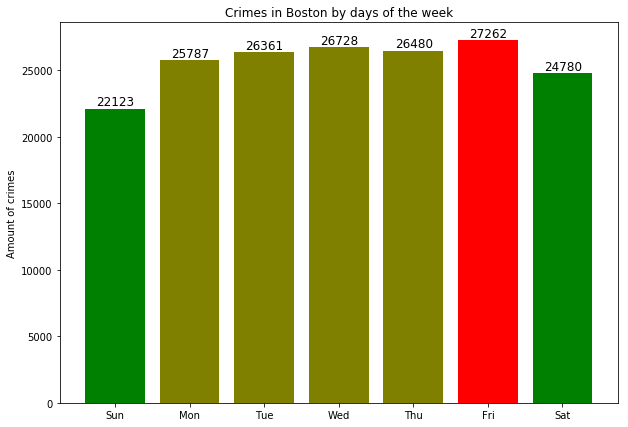

In [783]:
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(111)
ind = np.arange(7)
crimes_by_day = df_day['counts']
rects = ax.bar(ind, crimes_by_day, width = 0.8, color = ['green','olive','olive','olive','olive','red','green'])
ax.set_xticks(ind)
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_title('Crimes in Boston by days of the week')
ax.set_ylabel('Amount of crimes')
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + 0.15, height + 250, height, fontsize = 12)

<a id = 'year'></a>
[Return to top](#top)
## 2.2 Is the crime problem in Boston getting better or worse?

In [585]:
df_year = df_clean.groupby('year').size().reset_index(name = 'counts').set_index('year')

In [586]:
df_year

,counts
year,
2015,30292
2016,50515
2017,48456
2018,47488
2019,2770


Disregarding 2015 and 2019 since there are not enough data about them in the data set it is easy to see that the crime situation in 2017 is slightly better than the situation in 2016. The crime situation in 2018 is slightly better than the situation in 2017.

In [587]:
df_year.drop(labels = [2015,2019], inplace = True)

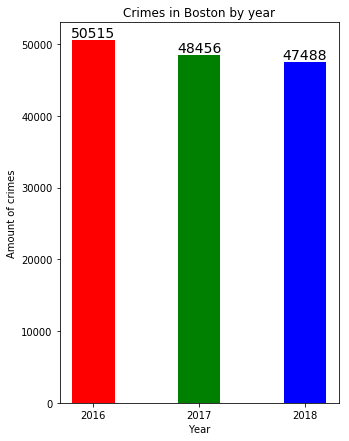

In [780]:
fig2 = plt.figure(figsize = (5,7))
ind2 = np.arange(3)
ax2 = plt.subplot(111)
rects = ax2.bar(ind2, df_year['counts'], width = 0.4, color = ['red','green','blue'])
ax2.set_xticks(ind2)
ax2.set_xticklabels([2016,2017,2018])
ax2.set_xlabel('Year')
ax2.set_ylabel('Amount of crimes')
ax2.set_title('Crimes in Boston by year')
for rect in rects:
    height = rect.get_height()
    ax2.text(rect.get_x() - 0.01, height + 400, height, fontsize = 14)

<a id = 'month'></a>
[Return to top](#top)
## 2.3 Crime and month

Are there more crimes in summers or in winters?

Since the data set is from Aug.2015 to Jan. 2019 let's analyze the trends from 2016 to 2018.

In [589]:
df_1618 = df_clean.loc[(df_clean['year'] > 2015) & (df_clean['year'] < 2019)]

In [590]:
df_1618.shape

(146459, 17)

In [591]:
df_month = df_1618.groupby('month').size().reset_index(name = 'counts').set_index('month')

In [592]:
df_month

,counts
month,
1,11933
2,10765
3,11760
4,12016
5,12947
6,13044
7,13198
8,13347
9,12642


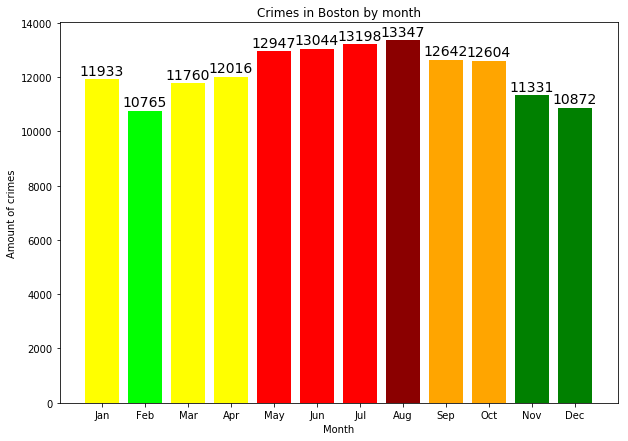

In [778]:
fig3 = plt.figure(figsize = (10,7))
ind3 = np.arange(12)
ax3 = plt.subplot(111)
rects = ax3.bar(ind3, df_month['counts'], width = 0.8,color = ['yellow','lime','yellow','yellow','red','red','red','darkred','orange','orange','green','green'])
ax3.set_xticks(ind3)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3.set_xlabel('Month')
ax3.set_ylabel('Amount of crimes')
ax3.set_title('Crimes in Boston by month')
for rect in rects:
    height = rect.get_height()
    ax3.text(rect.get_x() - 0.13, height + 150, height, fontsize = 14)

It seems that there is more crime during summer months and less crime during winter ones. It's possible that crime is fairly weather-dependent.

<a id = 'common'></a>
[Return to top](#top)
## 2.4 What are the most common crimes in Boston?

In [594]:
df_ocg = df_clean.groupby('offense_code_group').size().reset_index(name = 'counts').set_index('offense_code_group').sort_values(by = 'counts', ascending = False)

In [595]:
df_ocg

,counts
offense_code_group,
Larceny,29257
Other,19091
Drug Violation,18502
Simple Assault,17799
Vandalism,17132
Larceny From Motor Vehicle,12029
Aggravated Assault,8868
Violations,6730
Fraud,6660


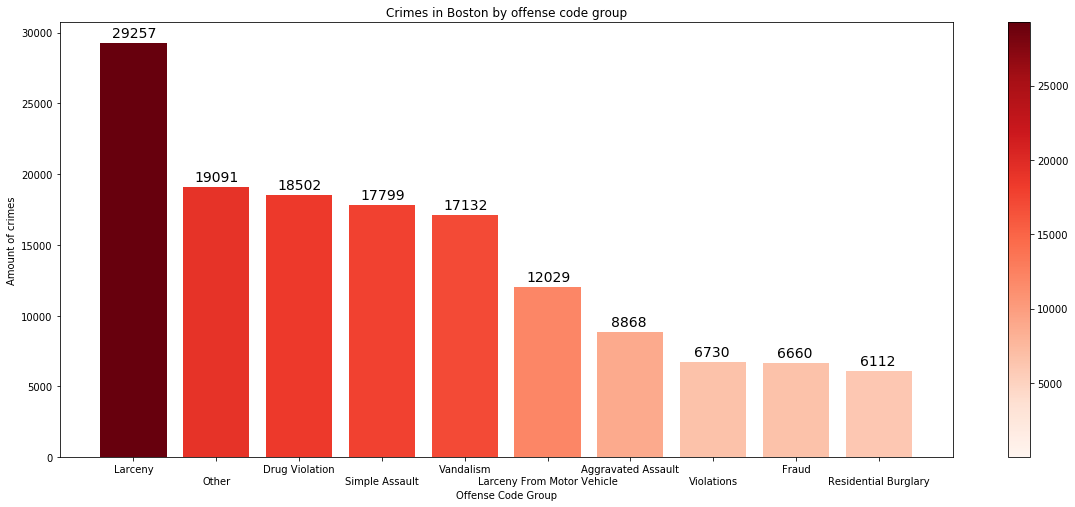

In [776]:
fig41 = plt.figure(figsize = (20,8))
ind41 = np.arange(10)
ax41 = plt.subplot(111)
y_data = df_ocg['counts'].head(10)
df_riocg = df_ocg.reset_index()
cmap = plt.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin = df_ocg['counts'].min(), vmax = df_ocg['counts'].max())
rects = ax41.bar(ind41, y_data, width = 0.8,color = cmap(norm(df_ocg.counts.values)))
ax41.set_xticks(ind41)
ax41.set_xticklabels(multiliner(df_ocg.index.tolist()[:10], 2))
ax41.set_xlabel('Offense Code Group')
ax41.set_ylabel('Amount of crimes')
ax41.set_title('Crimes in Boston by offense code group')
for rect in rects:
    height = rect.get_height()
    if height < 10000:
        pos = rect.get_x() + 0.17
    else:
        pos = rect.get_x() + 0.14
    ax41.text(pos, height + 400, height, fontsize = 14)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
fig41.colorbar(sm)
plt.show()

In terms of offense code groups the five most common crimes in Boston are larceny, other, drug violation, simple assault and vandalism.

In [597]:
df_od = df_clean.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description').sort_values(by = 'counts', ascending = False)

In [598]:
df_od

,counts
offense_description,
VANDALISM,16847
ASSAULT SIMPLE - BATTERY,16589
THREATS TO DO BODILY HARM,10233
LARCENY THEFT FROM BUILDING,10199
LARCENY THEFT FROM MV - NON-ACCESSORY,9865
LARCENY SHOPLIFTING,8990
LARCENY ALL OTHERS,6747
ASSAULT - AGGRAVATED - BATTERY,5544
FRAUD - FALSE PRETENSE / SCHEME,5033


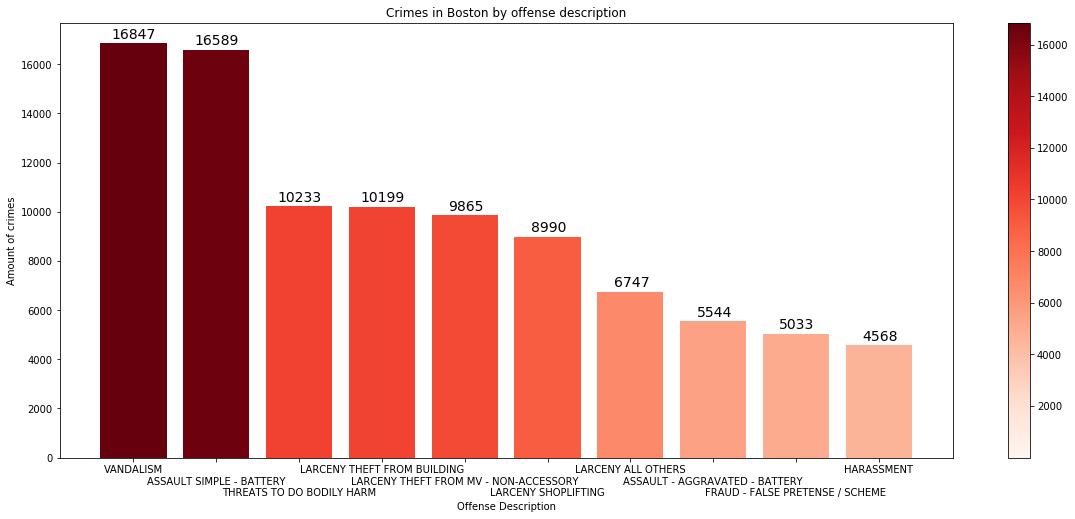

In [775]:
fig42 = plt.figure(figsize = (20,8))
ind42 = np.arange(10)
ax42 = plt.subplot(111)
cmap = plt.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin = df_od['counts'].min(), vmax = df_od['counts'].max())
y_data = df_od['counts'].head(10)
df_riod = df_od.reset_index()
rects = ax42.bar(ind42, y_data, width = 0.8,color = cmap(norm(df_od.counts.values)))
ax42.set_xticks(ind42)
ax42.set_xticklabels(multiliner(df_od.index.tolist()[:10], 3))
ax42.set_xlabel('Offense Description')
ax42.set_ylabel('Amount of crimes')
ax42.set_title('Crimes in Boston by offense description')
for rect in rects:
    height = rect.get_height()
    if height < 10000:
        pos = rect.get_x() + 0.2
    else:
        pos = rect.get_x() + 0.14
    ax42.text(pos, height + 200, height, fontsize = 14)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

In terms of offense descriptions the five most common crimes in Boston are vandalism, assault simple - battery, threats to do bodily harm, larceny theft from building and larceny threat from motor vehicle - non-accessory.

<a id = 'location'></a>
[Return to top](#top)
## 2.5 Where are crimes located in Boston?

In [600]:
df_districts = df_clean.groupby('district').size().reset_index(name = 'counts').set_index('district').sort_values('counts', ascending = False)

In [601]:
df_districts

,counts
district,
B2,28366
D4,27516
C11,22960
A1,22268
B3,18252
C6,13459
D14,10336
E13,9925
E18,8593


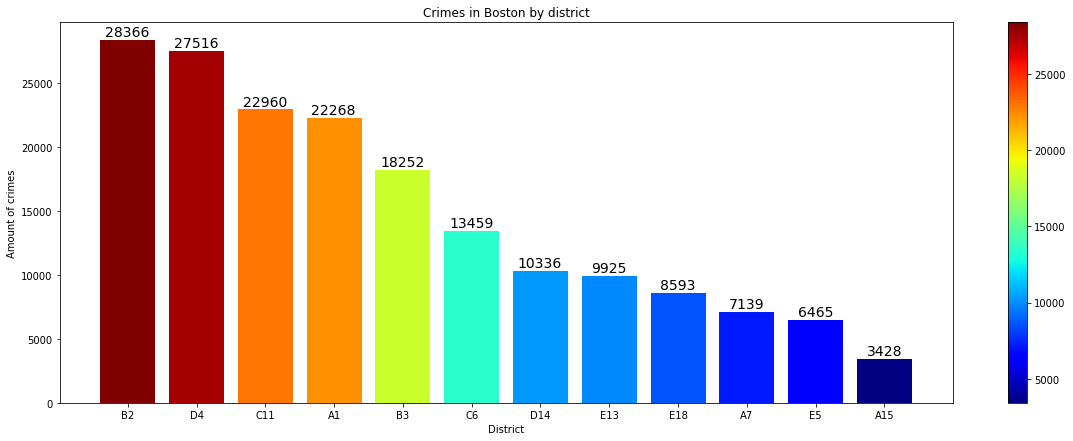

In [801]:
fig5 = plt.figure(figsize = (20,7))
ind5 = np.arange(12)
ax5 = plt.subplot(111)
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = df_districts['counts'].min(), vmax = df_districts['counts'].max())
rects = ax5.bar(ind5, df_districts['counts'], width = 0.8,color = cmap(norm(df_districts['counts'].values)))
ax5.set_xticks(ind5)
ax5.set_xticklabels(df_districts.index)
ax5.set_xlabel('District')
ax5.set_ylabel('Amount of crimes')
ax5.set_title('Crimes in Boston by district')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() + 0.07
    else:
        hor = rect.get_x() + 0.14
    ax5.text(hor, height + 300, height, fontsize = 14)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

It seems that B2, D4, C11 and A1 have the most crimes. On the other hand A15, A7, E18 and E13 have the least amount of crimes.

Analysis of whether a certain police district of Boston necessarily has more crimes compared to some other police district per capita is impossible because different police district differ a lot in terms of population size.

However analyzing the same information using neighborhood boundaries should be possible.

<a id = 'time'></a>
[Return to top](#top)
## 2.6 What time of day are crimes commited?

In [603]:
df_hour = df_clean.groupby('hour').size().reset_index(name = 'counts').set_index('hour')

In [713]:
df_hour

,counts
hour,
0,9250
1,5336
2,5360
3,3241
4,2038
5,1690
6,1913
7,3165
8,5490


The most crimes are commited between 4PM and 8PM. Between 1AM and 8AM few crimes are commited. There are two short bumps of crime between 12PM and 1PM and between 12AM and 1AM. On the other hand the period between 1AM and 8AM is fairly crime-free.

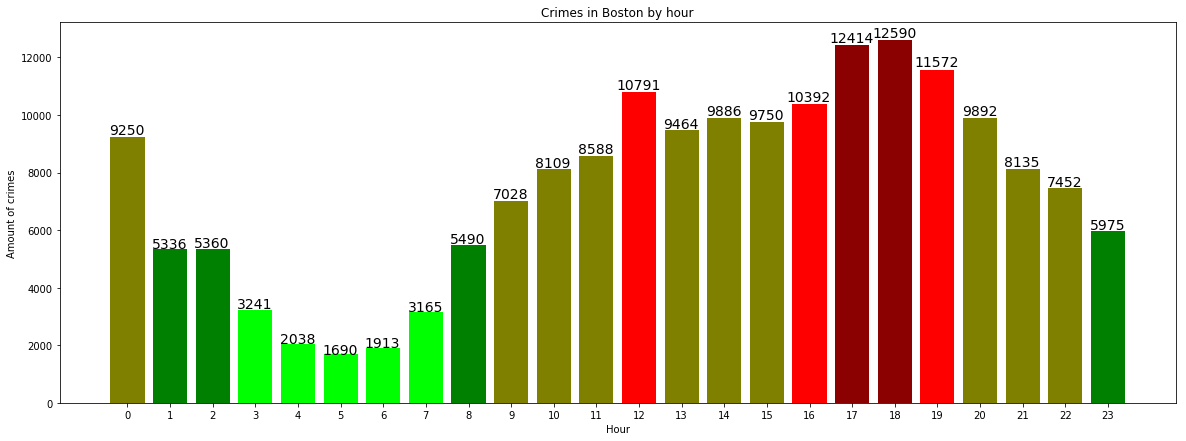

In [605]:
fig6 = plt.figure(figsize = (20,7))
ind6 = np.arange(24)
ax6 = plt.subplot(111)
color = []
for i in range(24):
    amount = df_hour.loc[i, 'counts']
    if amount > 12000:
        color.append('darkred')
    elif amount < 4000:
        color.append('lime')
    elif amount > 10000:
        color.append('r')
    elif amount < 6000:
        color.append('g')
    else:
        color.append('olive')
rects = ax6.bar(ind6, df_hour['counts'], width = 0.8,color = color)
ax6.set_xticks(ind6)
ax6.set_xticklabels(df_hour.index)
ax6.set_xlabel('Hour')
ax6.set_ylabel('Amount of crimes')
ax6.set_title('Crimes in Boston by hour')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.03
    ax6.text(hor, 1.01 * height, height, fontsize = 14)

[Return to top](#top)

<a id = "2.7"></a>
## 2.7 Which days of month have the most crimes?

In [717]:
df_daym = df_clean.groupby('day').size().reset_index(name = 'counts').set_index('day')

In [718]:
df_daym

,counts
day,
1,6705
2,5948
3,5692
4,5786
5,5747
6,5732
7,5867
8,5789
9,5589


The raw numbers are meaningless because 31sts are really rare. Moreover they are more common in summer months. To make things more meaningful we need to restrict to 2016-2018 and discount crimes that took place on Feb.29th, 2016 because we only consider 3 years.

In [734]:
df_16229 = df_1618[(df_1618['month'] == 2) & (df_1618['day'] == 29)]
amount229 = df_16229.shape[0]

In [738]:
df_daym = df_1618.groupby('day').size().reset_index(name = 'counts').set_index('day')

In [741]:
df_daym

,counts,rate
day,,
1,5612,155.888889
2,4872,135.333333
3,4648,129.111111
4,4707,130.750000
5,4734,131.500000
6,4715,130.972222
7,4816,133.777778
8,4724,131.222222
9,4545,126.250000


In [739]:
discount = 97/400
days = [36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 33 + 3 * discount, 33,
       21]
#df_daym.at[29, 'counts'] = df_daym.at[29, 'counts'] - amount229 + amount229 * 3 * discount
for i in range(31):
    if i == 28:#29!
        df_daym.at[i + 1, 'rate'] = (df_daym.at[29, 'counts'] - amount229 + amount229 * 3 * discount) / days[i]
    else:
        df_daym.at[i + 1, 'rate'] = df_daym.at[i + 1, 'counts'] / days[i]

In [740]:
df_daym

,counts,rate
day,,
1,5612,155.888889
2,4872,135.333333
3,4648,129.111111
4,4707,130.750000
5,4734,131.500000
6,4715,130.972222
7,4816,133.777778
8,4724,131.222222
9,4545,126.250000


It seems that crime is really roughly unrelated to day of the month other than 1sts being surprisingly criminal.

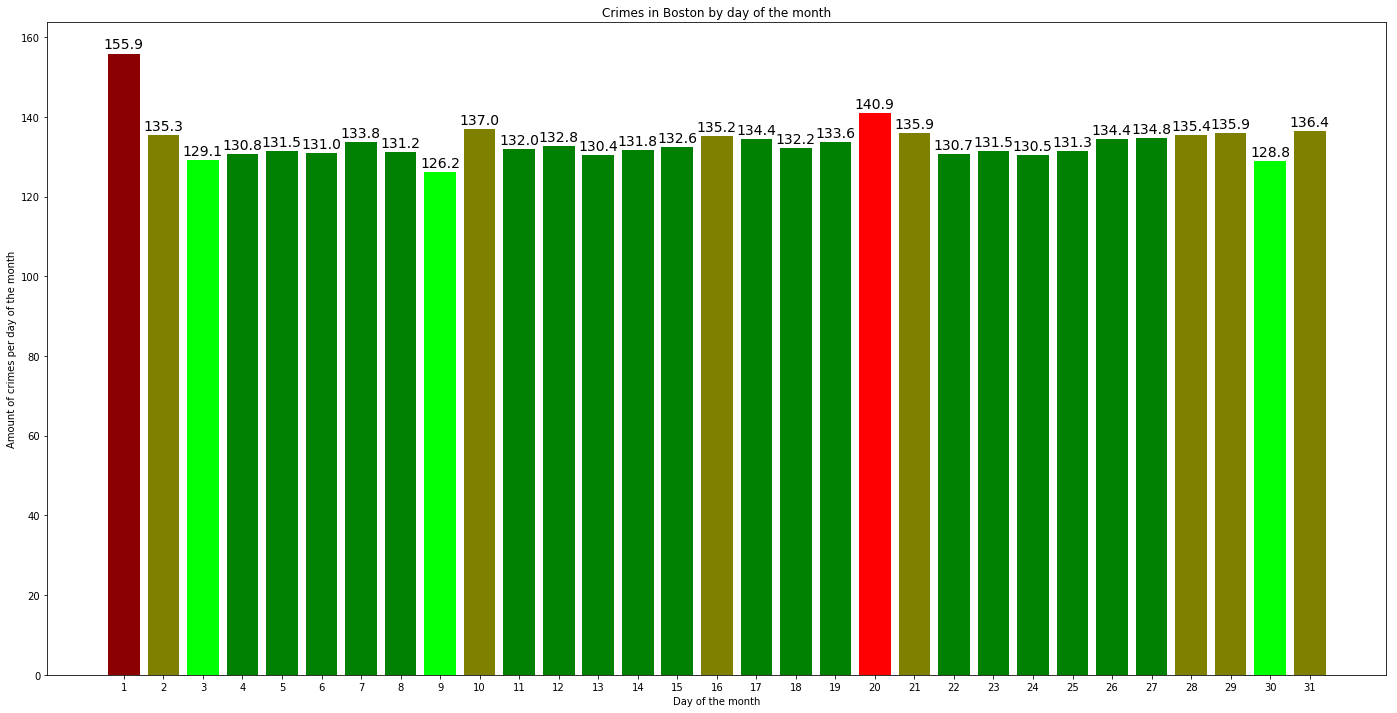

In [754]:
fig7a = plt.figure(figsize = (24,12))
ind7a = np.arange(1, 32)
ax7a = plt.subplot(111)
color = []
for i in range(1, 32):
    amount = df_daym.loc[i, 'rate']
    if amount > 150:
        color.append('darkred')
    elif amount < 130:
        color.append('lime')
    elif amount > 140:
        color.append('r')
    elif amount < 135:
        color.append('g')
    else:
        color.append('olive')
rects = ax7a.bar(ind7a, df_daym['rate'], width = 0.8,color = color)
ax7a.set_xticks(ind7a)
ax7a.set_xticklabels(df_daym.index)
ax7a.set_xlabel('Day of the month')
ax7a.set_ylabel('Amount of crimes per day of the month')
ax7a.set_title('Crimes in Boston by day of the month')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.03
    ax7a.text(hor - 0.08, 1.01 * height - 0.14, "{:.1f}".format(height), fontsize = 14)

<a id = 'shooting'></a>
[Return to top](#top)
## 2.8 How many crimes involve shooting?

In [606]:
df_shooting = df_clean.groupby('shooting').size().reset_index(name = 'counts').set_index('shooting')

In [607]:
df_shooting

,counts
shooting,
0,178333
Y,1188


OK so Y represents shooting.

In [608]:
shooting_rate = df_shooting.loc['Y', 'counts']/df_clean.shape[0]

In [609]:
shooting_rate

0.006617610196021635

About 0.66% of all crimes involve shooting.

Text(0.5,1,'What percentage of crimes involve shooting?')

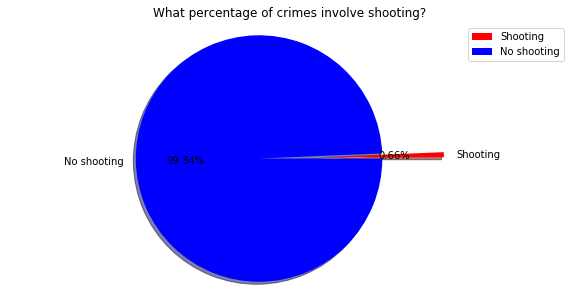

In [610]:
fig7 = plt.figure(figsize = (10,5))
labels = ['Shooting', 'No shooting']
ax7 = plt.subplot(111)
size = [shooting_rate, 1 - shooting_rate]
ax7.pie(size, explode = [0.5,0], labels = labels, autopct = '%1.2f%%', shadow = True, colors = ['red','blue'])
ax7.axis('equal')
ax7.legend()
ax7.set_title('What percentage of crimes involve shooting?')

<a id = 'crime_rates'></a>
[Return to top](#top)
# 3. Crime rates of neighborhoods of Boston

We are going to continue our exploration in 2.5 . It is impossible to calculate the population of police districts. However the population of neighborhoods of Boston are still possible to obtain. We are going to use the definitions of neighborhoods on the [Analyze Boston](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0) website.

<a id = '3.0'></a>
## 3.1 Calculate the population of each neighborhood of Boston

In [611]:
import json
with open('Boston_Neighborhoods.geojson', 'r') as f:
    boston_geojson = json.load(f)
features = boston_geojson['features']
nbh_list = []
for feature in features:
    nbh_list.append(feature['properties']['Name'])
print(nbh_list)

['Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston', 'Harbor Islands']


In [612]:
boston_geojson['features'][0]['geometry']

{'type': 'MultiPolygon',
 'coordinates': [[[[-71.12592717485386, 42.272013107957406],
    [-71.12610933458738, 42.2716219294518],
    [-71.12603188298199, 42.27158985153841],
    [-71.12571713956957, 42.27152070474045],
    [-71.12559042372907, 42.27146017841939],
    [-71.12523676125656, 42.271387313901805],
    [-71.12522437821433, 42.271425073651166],
    [-71.12489533053173, 42.27134458090032],
    [-71.12482468090687, 42.271318140479686],
    [-71.12485155056099, 42.27124753819149],
    [-71.12476329046935, 42.270292339717635],
    [-71.12470249712558, 42.270295367758344],
    [-71.12259088359436, 42.2700534081311],
    [-71.1223931813923, 42.27003085475475],
    [-71.12252039300371, 42.269427196690025],
    [-71.12214745279846, 42.26937277217365],
    [-71.12192848881409, 42.27038614438027],
    [-71.1221406576364, 42.27041692631439],
    [-71.1220178727131, 42.27096341291406],
    [-71.12201165286537, 42.271016446462525],
    [-71.12190239148987, 42.27099668884986],
    [-71.121

In [613]:
nbh_list.sort()

In [614]:
nbh_list

['Allston',
 'Back Bay',
 'Bay Village',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Chinatown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Leather District',
 'Longwood',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South Boston Waterfront',
 'South End',
 'West End',
 'West Roxbury']

Now it's time to determine the population of each neighborhood. The data is also obtained from [Analyze Boston](https://data.boston.gov/dataset/boston-neighborhood-demographics) because different websites have completely different definitions of many neighborhoods. Here according to the City of Boston Chinatown and Leather district have been merged into Downtown and Bay Village is merged into South End.

In [615]:
nbh_list.remove('Chinatown')
nbh_list.remove('Bay Village')
nbh_list.remove('Leather District')

In [616]:
nbh_list

['Allston',
 'Back Bay',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Longwood',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South Boston Waterfront',
 'South End',
 'West End',
 'West Roxbury']

In [617]:
nbh_pop = {
    'Allston':22312,
 'Back Bay':16622,
 'Beacon Hill':9023,
 'Brighton':52685,
 'Charlestown':16439,
 'Dorchester':114249,
 'Downtown':15992,
 'East Boston':40508,
 'Fenway':33895,
 'Harbor Islands':535,
 'Hyde Park':32317,
 'Jamaica Plain':35541,
 'Longwood':4861,
 'Mattapan':22500,
 'Mission Hill':16874,
 'North End':8608,
 'Roslindale':26368,
 'Roxbury':49111,
 'South Boston':31110,
 'South Boston Waterfront':2564,
 'South End':29612,
 'West End':5423,
 'West Roxbury':30445
}

In [618]:
df_nb = pd.DataFrame.from_dict(data = nbh_pop, orient = 'index', columns = ['population'])

In [619]:
df_nb

,population
Allston,22312
Back Bay,16622
Beacon Hill,9023
Brighton,52685
Charlestown,16439
Dorchester,114249
Downtown,15992
East Boston,40508
Fenway,33895
Harbor Islands,535


We need to preserve the data.

In [620]:
df_nb.to_csv('population.csv')

<a id = '3.1'></a>
[Return to top](#top)
## 3.2 Determining the neighborhood in which a crime took place

Since we already have the information about the population of the neighborhoods. Now we need to determine the number of crimes that take place within a neighborhood. All the crimes that did not have latitude and longitude need to be dropped so we may have some slight underestimation and distortion.

In order to do so we need to make sure that we can attribute a crime to a neighborhood we need to use the Geojson data from [Analyze Boston](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0).

In [621]:
from shapely.geometry import Point, shape

In [622]:
def point_to_neighborhood (lat, long, geojson):
    point = Point(long, lat)
    features = geojson['features']
    for feature in features:
        polygon = shape(feature['geometry'])
        neighborhood = feature['properties']['Name']
        if polygon.contains(point):
            if neighborhood == 'Chinatown' or neighborhood == 'Leather District':
                return 'Downtown'
            elif neighborhood == 'Bay Village':
                return 'South End'
            else:
                return neighborhood
    #print(f'Point ({long},{lat}) is not in Boston.')
    return None

In [623]:
boston_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 27,
    'Name': 'Roslindale',
    'Acres': 1605.5682375,
    'Neighborhood_ID': '15',
    'SqMiles': 2.51,
    'ShapeSTArea': 69938272.92557049,
    'ShapeSTLength': 53563.912597056624},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-71.12592717485386, 42.272013107957406],
       [-71.12610933458738, 42.2716219294518],
       [-71.12603188298199, 42.27158985153841],
       [-71.12571713956957, 42.27152070474045],
       [-71.12559042372907, 42.27146017841939],
       [-71.12523676125656, 42.271387313901805],
       [-71.12522437821433, 42.271425073651166],
       [-71.12489533053173, 42.27134458090032],
       [-71.12482468090687, 42.271318140479686],
       [-71.12485155056099, 42.27124753819149],
       [-71.12476329046935, 42.270292339717635],
       [-71.12470249712558, 42.270295367758344],
       [-71.12259088359436, 42.2700534081311],
       [-71.1223931813923, 42.270030

In [624]:
point_to_neighborhood(42.372269, -71.039015, boston_geojson)

'East Boston'

In [625]:
df_nafree = df_clean.dropna(subset = ['lat','long'])

In [626]:
df_nafree.shape

(169577, 17)

In [627]:
df_nafree.shape[0]/df_clean.shape[0]

0.9446081516925596

So we can retain 94%+ of the data. That's good.

In [628]:
for index, row in df_nafree.iterrows():
    lat = df_nafree.at[index, 'lat']
    long = df_nafree.at[index, 'long']
    #print(index)
    #print(lat)
    #print(long)
    neighborhood = point_to_neighborhood(lat, long, boston_geojson)
    #print(neighborhood)
    df_nafree.at[index, 'Neighborhood'] = neighborhood


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [629]:
df_nafree.tail(10)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day,day_of_week,hour,ucr_part,street,lat,long,Neighborhood
358052,I152049952,2647,Other,THREATS TO DO BODILY HARM,C11,356.0,0,2015-06-16 15:10:00,2015,6,16,Tuesday,15,Part Two,GENEVA AVE,42.298489,-71.063133,Dorchester
358053,I152049866,1815,Drug Violation,DRUGS - POSSESSION,A1,111.0,0,2015-06-16 12:16:00,2015,6,16,Tuesday,12,Part Two,BOYLSTON ST,42.352329,-71.064103,Downtown
358057,I152049477,1402,Vandalism,VANDALISM,B3,466.0,0,2015-06-15 12:00:00,2015,6,15,Monday,12,Part Two,ESTELLA ST,42.286874,-71.094571,Mattapan
358058,I152030570-00,404,Aggravated Assault,"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",E13,303.0,0,2016-10-29 08:25:00,2016,10,29,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799,Jamaica Plain
358059,I152002219-00,339,Robbery,ROBBERY - UNARMED - STREET,B2,260.0,0,2016-01-23 02:20:00,2016,1,23,Saturday,2,Part One,FOLSOM ST,42.317972,-71.072345,Roxbury
358061,I142017108-00,1841,Drug Violation,DRUGS - POSS CLASS A - INTENT TO MFR DIST DISP,A1,64.0,0,2015-06-16 15:55:00,2015,6,16,Tuesday,16,Part Two,FRUIT ST,42.362403,-71.069547,West End
358062,I140212767-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,E13,303.0,0,2018-09-17 18:54:00,2018,9,17,Monday,19,Part Two,AMORY ST,42.320272,-71.099325,Jamaica Plain
358063,I130634867-00,511,Residential Burglary,B&E RESIDENCE NIGHT - ATTEMPT FORCE,A1,114.0,0,2015-08-10 19:13:00,2015,8,10,Monday,19,Part One,ATLANTIC AVE,42.352659,-71.055353,Downtown
358064,I130041200-00,540,Commercial Burglary,B&E NON-RESIDENCE DAY - FORCIBLE,B3,428.0,0,2015-12-07 11:38:00,2015,12,7,Monday,12,Part One,DIXWELL ST,42.314334,-71.097914,Jamaica Plain
358065,I110261417-00,619,Larceny,LARCENY OTHER $200 & OVER,B2,324.0,0,2016-07-29 00:00:00,2016,7,29,Friday,0,Part One,BOWDOIN ST,42.307038,-71.066153,Dorchester


Now it is time to first store the data and then calculate the crime rates.

In [630]:
df_nafree.to_csv('crimes_with_neighborhoods.csv')

In [631]:
df_nbh = df_nafree.groupby('Neighborhood').size().reset_index(name = 'count').set_index('Neighborhood')

In [632]:
df_nbh

,count
Neighborhood,
Allston,4697
Back Bay,8965
Beacon Hill,1399
Brighton,5300
Charlestown,3025
Dorchester,40437
Downtown,15590
East Boston,7020
Fenway,5516


In [633]:
df_nafree['Neighborhood'].isna().sum()

497

The 497 new NANs don't matter much. However we should still understand why they are NANs. Most of them are literally (-1,-1)s that should have been considered NaN. The rest are actually in Boston but since they are near the boundaries of Boston the Geojson left them out of Boston. It is impossible to determine the exact neighborhood of these cases which is why we have to drop them.

<a id = '3.2'></a>
[Return to top](#top)
## 3.3 Calculate the crime rates

In [634]:
df_nbh.index.size

22

All neighborhoods are present except for the 3 that got merged into other neighborhoods and Harbor Islands which is basically almost unpopulated.

In [635]:
df_nbh_full = pd.concat([df_nb,df_nbh],axis = 1, sort = True)

In [636]:
df_nbh_full

,population,count
Allston,22312,4697.0
Back Bay,16622,8965.0
Beacon Hill,9023,1399.0
Brighton,52685,5300.0
Charlestown,16439,3025.0
Dorchester,114249,40437.0
Downtown,15992,15590.0
East Boston,40508,7020.0
Fenway,33895,5516.0
Harbor Islands,535,NaN


In [637]:
df_nbh_full.at['Harbor Islands','count'] = 0

In [638]:
for index, row in df_nbh_full.iterrows():
    df_nbh_full.at[index, 'Crime rate'] = df_nbh_full.at[index, 'count'] / df_nbh_full.at[index, 'population']

In [639]:
df_nbh_full = df_nbh_full.sort_values('Crime rate', ascending = False)

In [640]:
df_nbh_full

,population,count,Crime rate
Downtown,15992,15590.0,0.974862
Back Bay,16622,8965.0,0.539345
Roxbury,49111,22850.0,0.465273
Dorchester,114249,40437.0,0.353937
West End,5423,1852.0,0.341508
Mattapan,22500,7023.0,0.312133
South End,29612,8486.0,0.286573
South Boston,31110,8496.0,0.273095
South Boston Waterfront,2564,695.0,0.271061
Jamaica Plain,35541,8473.0,0.238401


Downtown appears unusually dangerous. However it seems that it should be an outlier because most people who pass through downtown Boston including most criminals don't actually live there. At the same time Harbor islands isn't really necessarily completely crime-free. Instead what's more likely is that it is so isolated that incidents there are unlikely to be known to the Boston Police.

Now we need to normalize the crime rate using time. To do so we first need to understand the time range.

In [641]:
df.tail(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day,day_of_week,hour,ucr_part,street,lat,long
358061,I142017108-00,1841,Drug Violation,DRUGS - POSS CLASS A - INTENT TO MFR DIST DISP,A1,64.0,0,2015-06-16 15:55:00,2015,6,16,Tuesday,16,Part Two,FRUIT ST,42.362403,-71.069547
358062,I140212767-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,E13,303.0,0,2018-09-17 18:54:00,2018,9,17,Monday,19,Part Two,AMORY ST,42.320272,-71.099325
358063,I130634867-00,511,Residential Burglary,B&E RESIDENCE NIGHT - ATTEMPT FORCE,A1,114.0,0,2015-08-10 19:13:00,2015,8,10,Monday,19,Part One,ATLANTIC AVE,42.352659,-71.055353
358064,I130041200-00,540,Commercial Burglary,B&E NON-RESIDENCE DAY - FORCIBLE,B3,428.0,0,2015-12-07 11:38:00,2015,12,7,Monday,12,Part One,DIXWELL ST,42.314334,-71.097914
358065,I110261417-00,619,Larceny,LARCENY OTHER $200 & OVER,B2,324.0,0,2016-07-29 00:00:00,2016,7,29,Friday,0,Part One,BOWDOIN ST,42.307038,-71.066153


In [724]:
df.sort_values(by = ['year','month','day']).head(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day,day_of_week,hour,ucr_part,street,lat,long
84092,I182061268,3201,Property Lost,PROPERTY - LOST,NaN,NaN,0,2015-06-15 00:00:00,2015,6,15,Monday,0,Part Three,BERNARD,-1.000000,-1.000000
125829,I162055778,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159.0,0,2015-06-15 09:00:00,2015,6,15,Monday,9,Part Two,DARTMOUTH ST,42.342830,-71.073747
179328,I152049769,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,D4,624.0,0,2015-06-15 22:13:00,2015,6,15,Monday,22,Part Three,BROOKLINE AVE,42.347462,-71.098266
179329,I152049678,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A1,113.0,0,2015-06-15 15:15:00,2015,6,15,Monday,15,Part Two,FINANCIAL CTR,NaN,NaN
179330,I152049586,3301,Verbal Disputes,VERBAL DISPUTE,E5,682.0,0,2015-06-15 12:45:00,2015,6,15,Monday,13,Part Three,BERYL ST,42.282814,-71.139320


In [725]:
df.sort_values(by = ['year','month','day']).tail(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day,day_of_week,hour,ucr_part,street,lat,long
11313,I192006806,3803,Motor Vehicle Accident Response,M/V ACCIDENT - PERSONAL INJURY,A7,15.0,0,2019-01-26 13:32:00,2019,1,26,Saturday,14,Part Three,SARATOGA ST,42.381734,-71.022642
11314,I192006731,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,E13,304.0,0,2019-01-26 03:57:00,2019,1,26,Saturday,4,Part Three,WASHINGTON ST,42.316152,-71.097951
11599,I192006869,3115,Investigate Person,INVESTIGATE PERSON,B3,465.0,0,2019-01-26 18:34:00,2019,1,26,Saturday,19,Part Three,BLUE HILL AVE,42.284826,-71.091374
11990,I192006798,3115,Investigate Person,INVESTIGATE PERSON,A15,43.0,0,2019-01-26 13:37:00,2019,1,26,Saturday,14,Part Three,OLD IRONSIDES WAY,42.380205,-71.057414
11991,I192006718,3114,Investigate Property,INVESTIGATE PROPERTY,B3,439.0,0,2019-01-26 00:44:00,2019,1,26,Saturday,1,Part Three,TALBOT AVE,42.292687,-71.080384


So we have 1322 days.

In [644]:
for index, row in df_nbh_full.iterrows():
    df_nbh_full.at[index, 'Crime rate'] = df_nbh_full.at[index, 'Crime rate'] * 365 / 1322

Since people usually calculate crime rate per 100,000 residents we will do so.

In [645]:
for index, row in df_nbh_full.iterrows():
    df_nbh_full.at[index, 'Crime rate'] = df_nbh_full.at[index, 'Crime rate'] * 100000

In [646]:
df_nbh_full

,population,count,Crime rate
Downtown,15992,15590.0,26915.642012
Back Bay,16622,8965.0,14891.156408
Roxbury,49111,22850.0,12846.027174
Dorchester,114249,40437.0,9772.100615
West End,5423,1852.0,9428.938156
Mattapan,22500,7023.0,8617.902168
South End,29612,8486.0,7912.189788
South Boston,31110,8496.0,7540.079101
South Boston Waterfront,2564,695.0,7483.903743
Jamaica Plain,35541,8473.0,6582.168147


In [647]:
df_nbh_full.index

Index(['Downtown', 'Back Bay', 'Roxbury', 'Dorchester', 'West End', 'Mattapan',
       'South End', 'South Boston', 'South Boston Waterfront', 'Jamaica Plain',
       'Allston', 'Hyde Park', 'Mission Hill', 'Charlestown', 'East Boston',
       'Roslindale', 'Fenway', 'Longwood', 'Beacon Hill', 'North End',
       'West Roxbury', 'Brighton', 'Harbor Islands'],
      dtype='object')

In [648]:
multiliner(['a','b','c'],3)

['a', '\nb', '\n\nc']

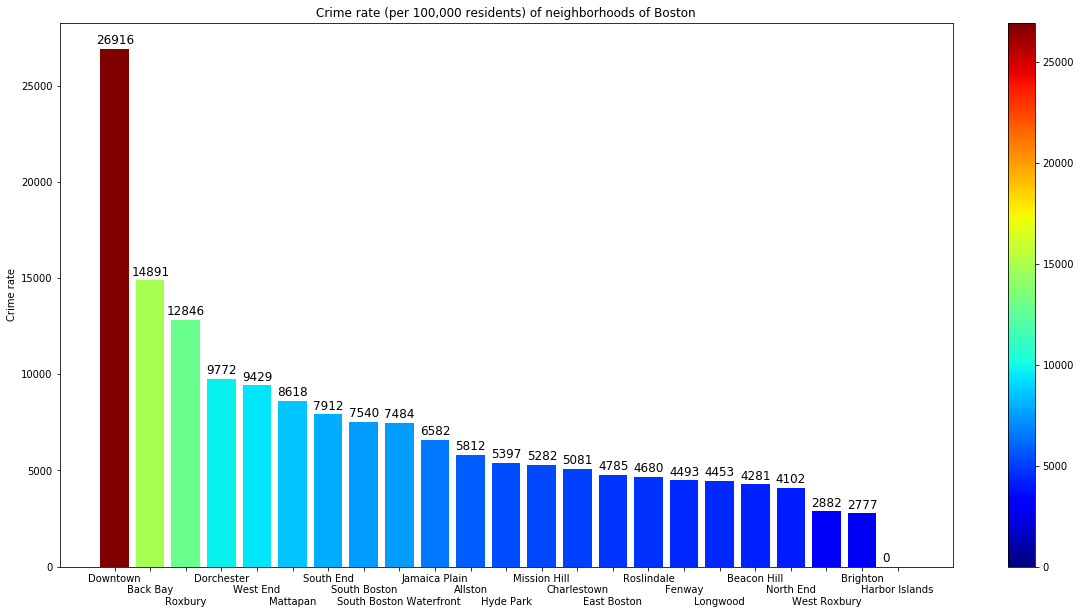

In [800]:
fig0 = plt.figure(figsize = (20,10))
ax0 = plt.subplot(111)
ind0 = np.arange(23)
crime_rate_by_neighborhood = df_nbh_full['Crime rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = df_nbh_full['Crime rate'].min(), vmax = df_nbh_full['Crime rate'].max())
rects = ax0.bar(ind0, crime_rate_by_neighborhood, width = 0.8, color = cmap(norm(df_nbh_full['Crime rate'].values)))
ax0.set_xticks(ind0)
ax0.set_xticklabels(multiliner(df_nbh_full.index.tolist(),3))
ax0.set_title('Crime rate (per 100,000 residents) of neighborhoods of Boston')
ax0.set_ylabel('Crime rate')
for rect in rects:
    height = rect.get_height()
    if height >= 9999.5:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.02
    ax0.text(hor, height + 250, int(round(height)), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

<a id = '4'></a>
[Return to top](#top)
# 4. Rates of particular crimes

Now let's focus on the actual categories UCR use. We will focus on violent crimes (defined as murder and nonnegligent manslaughter, rape, robbery, and aggravated assault), property crimes (defined as burglary, larceny-theft, and motor vehicle theft) and arson.

Before doing so we first need to drop some NaNs.

In [650]:
df_particulars = df_nafree.dropna(subset = ['Neighborhood'])

In [651]:
df_particulars.shape

(169080, 18)

In [652]:
df_particulars['offense_description'].unique().tolist()

['VANDALISM',
 'BURGLARY - RESIDENTIAL - NO FORCE',
 'LARCENY ALL OTHERS',
 'HARASSMENT',
 'LARCENY SHOPLIFTING',
 'VAL - OPERATING WITHOUT LICENSE',
 'FRAUD - FALSE PRETENSE / SCHEME',
 'DRUGS - SICK ASSIST - HEROIN',
 'DRUGS - POSS CLASS B - COCAINE, ETC.',
 'ASSAULT - AGGRAVATED - BATTERY',
 'LARCENY THEFT FROM BUILDING',
 'OTHER OFFENSE',
 'LARCENY THEFT FROM MV - NON-ACCESSORY',
 'THREATS TO DO BODILY HARM',
 'BURGLARY - COMMERICAL - FORCE',
 'ASSAULT SIMPLE - BATTERY',
 'DISORDERLY CONDUCT',
 'DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP',
 'VIOL. OF RESTRAINING ORDER W NO ARREST',
 'ASSAULT - AGGRAVATED',
 'EVADING FARE',
 'VAL - OPERATING AFTER REV/SUSP.',
 'PROPERTY - STOLEN THEN RECOVERED',
 'FORGERY / COUNTERFEITING',
 'DRUGS - POSS CLASS D - INTENT TO MFR DIST DISP',
 'EXTORTION OR BLACKMAIL',
 'AUTO THEFT - LEASED/RENTED VEHICLE',
 'ROBBERY - COMMERCIAL',
 'BURGLARY - RESIDENTIAL - FORCE',
 'VAL - OPERATING UNREG/UNINS \xa0CAR',
 'DRUGS - POSS CLASS A - HEROIN, ETC.',
 '

In [653]:
df_particulars['offense_code_group'].unique().tolist()

['Vandalism',
 'Residential Burglary',
 'Larceny',
 'Harassment',
 'Violations',
 'Fraud',
 'Drug Violation',
 'Aggravated Assault',
 'Other',
 'Larceny From Motor Vehicle',
 'Commercial Burglary',
 'Simple Assault',
 'Disorderly Conduct',
 'Restraining Order Violations',
 'Evading Fare',
 'Recovered Stolen Property',
 'Counterfeiting',
 'Auto Theft',
 'Robbery',
 'Fire Related Reports',
 'Liquor Violation',
 'Confidence Games',
 'Other Burglary',
 'HOME INVASION',
 'Firearm Violations',
 'Ballistics',
 'Offenses Against Child / Family',
 'Homicide',
 'Arson',
 'Prisoner Related Incidents',
 'Auto Theft Recovery',
 'Operating Under the Influence',
 'Prostitution',
 'Bomb Hoax',
 'Embezzlement',
 'Phone Call Complaints',
 'Criminal Harassment',
 'License Plate Related Incidents',
 'Missing Person Reported',
 'Explosives',
 'HUMAN TRAFFICKING',
 'Gambling',
 'Manslaughter',
 'Biological Threat',
 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE',
 'Burglary - No Property Taken']

UCR Part II offenses should be irrelevant. However we still need to make sure. NANs in ucr_part are already irrelevant.

In [654]:
df_p2 = df_particulars.loc[df['ucr_part'] == 'Part Two']

In [655]:
df_2p = df_p2.groupby('offense_code_group').size().reset_index(name = 'count').set_index('offense_code_group')

In [656]:
df_2p

,count
offense_code_group,
Ballistics,1050
Biological Threat,2
Bomb Hoax,97
Confidence Games,3430
Counterfeiting,1616
Criminal Harassment,145
Disorderly Conduct,2593
Drug Violation,16368
Embezzlement,344


It is clear that they are irrelevant. Hence we will drop them.

In [657]:
df_p1 = df_particulars.loc[df['ucr_part'] == 'Part One']

In [658]:
df_1p = df_p1.groupby('offense_code_group').size().reset_index(name = 'count').set_index('offense_code_group')

In [659]:
df_1p

,count
offense_code_group,
Aggravated Assault,8242
Auto Theft,4930
Commercial Burglary,1444
Homicide,226
Larceny,28353
Larceny From Motor Vehicle,11382
Other Burglary,499
Residential Burglary,6074
Robbery,4643


<a id = '4.1'></a>
[Return to top](#top)
## 4.1 Where are the rape reports?

OK so we should tackle arson separately first. However we first need to find rapes.

In [660]:
df_1d = df_p1.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [661]:
df_1d

,count
offense_description,
"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",1
ASSAULT & BATTERY D/W - KNIFE,2
ASSAULT & BATTERY D/W - OTHER,9
ASSAULT & BATTERY D/W - OTHER ON POLICE OFFICER,1
ASSAULT - AGGRAVATED,3076
ASSAULT - AGGRAVATED - BATTERY,5150
ASSAULT D/W - KNIFE ON POLICE OFFICER,1
ASSAULT D/W - OTHER,2
AUTO THEFT,3662


Again there is no rape. Let's check again.

In [662]:
l_op = df.groupby('offense_code_group').size().reset_index(name = 'counts')['offense_code_group'].tolist()

In [663]:
l_op

['Aggravated Assault',
 'Aircraft',
 'Arson',
 'Assembly or Gathering Violations',
 'Auto Theft',
 'Auto Theft Recovery',
 'Ballistics',
 'Biological Threat',
 'Bomb Hoax',
 'Burglary - No Property Taken',
 'Commercial Burglary',
 'Confidence Games',
 'Counterfeiting',
 'Criminal Harassment',
 'Disorderly Conduct',
 'Drug Violation',
 'Embezzlement',
 'Evading Fare',
 'Explosives',
 'Fire Related Reports',
 'Firearm Discovery',
 'Firearm Violations',
 'Fraud',
 'Gambling',
 'HOME INVASION',
 'HUMAN TRAFFICKING',
 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE',
 'Harassment',
 'Harbor Related Incidents',
 'Homicide',
 'INVESTIGATE PERSON',
 'Investigate Person',
 'Investigate Property',
 'Landlord/Tenant Disputes',
 'Larceny',
 'Larceny From Motor Vehicle',
 'License Plate Related Incidents',
 'License Violation',
 'Liquor Violation',
 'Manslaughter',
 'Medical Assistance',
 'Missing Person Located',
 'Missing Person Reported',
 'Motor Vehicle Accident Response',
 'Offenses Against Child /

In [664]:
l_od = df.groupby('offense_description').size().reset_index(name = 'counts')['offense_description'].tolist()

In [665]:
l_od

['A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.',
 'A&B ON POLICE OFFICER',
 'ABDUCTION - INTICING',
 'AFFRAY',
 'AIRCRAFT INCIDENTS',
 'ANIMAL ABUSE',
 'ANIMAL CONTROL - DOG BITES - ETC.',
 'ANIMAL INCIDENTS',
 'ANNOYING AND ACCOSTIN',
 'ANNOYING AND ACCOSTING',
 'ARSON',
 'ASSAULT & BATTERY',
 'ASSAULT & BATTERY D/W - KNIFE',
 'ASSAULT & BATTERY D/W - OTHER',
 'ASSAULT & BATTERY D/W - OTHER ON POLICE OFFICER',
 'ASSAULT - AGGRAVATED',
 'ASSAULT - AGGRAVATED - BATTERY',
 'ASSAULT - SIMPLE',
 'ASSAULT D/W - KNIFE ON POLICE OFFICER',
 'ASSAULT D/W - OTHER',
 'ASSAULT SIMPLE - BATTERY',
 'AUTO THEFT',
 'AUTO THEFT - LEASED/RENTED VEHICLE',
 'AUTO THEFT - MOTORCYCLE / SCOOTER',
 'AUTO THEFT - OUTSIDE - RECOVERED IN BOSTON',
 'AUTO THEFT - RECOVERED IN BY POLICE',
 'AUTO THEFT LEASE/RENT VEHICLE',
 'AUTO THEFT OTHER',
 'B&E NON-RESIDENCE DAY - FORCIBLE',
 'B&E NON-RESIDENCE DAY - NO FORCE',
 'B&E NON-RESIDENCE DAY - NO PROP TAKEN',
 'B&E NON-RESIDENCE NIGHT - FORCE',
 'B&E RESIDENCE DAY - N

OK. So there is indeed no rapes reported at all. This implies nothing other than the data being flawed.

Now we can finally begin to calculate the rates of crimes other than rape.

<a id = '4.2'></a>
[Return to top](#top)
## 4.2 Violent crimes

Let's first calculate the rates of violent crimes. Let's start from murder.

In [666]:
df_murder = df_particulars.loc[df_particulars['offense_description'] == 'MURDER, NON-NEGLIGIENT MANSLAUGHTER']

In [667]:
df_murdern = df_murder.groupby('Neighborhood').size().reset_index(name = 'murder_and_nonnegligent_manslaughter').set_index('Neighborhood')

In [668]:
df_murdern

,murder_and_nonnegligent_manslaughter
Neighborhood,
Brighton,3
Charlestown,1
Dorchester,91
Downtown,5
East Boston,10
Fenway,5
Hyde Park,9
Jamaica Plain,15
Mattapan,28


Now let's move on to aggravated assults.

In [669]:
df_aa = df_particulars.loc[df_particulars['offense_code_group'] == 'Aggravated Assault']

In [670]:
df_aa_d = df_aa.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [671]:
df_aa_d

,count
offense_description,
"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",1
ASSAULT & BATTERY D/W - KNIFE,2
ASSAULT & BATTERY D/W - OTHER,9
ASSAULT & BATTERY D/W - OTHER ON POLICE OFFICER,1
ASSAULT - AGGRAVATED,3076
ASSAULT - AGGRAVATED - BATTERY,5150
ASSAULT D/W - KNIFE ON POLICE OFFICER,1
ASSAULT D/W - OTHER,2


Now I think we should check the neighborhoods.

In [672]:
df_aan = df_aa.groupby('Neighborhood').size().reset_index(name = 'aggravated_assault').set_index('Neighborhood')

In [673]:
df_aan

,aggravated_assault
Neighborhood,
Allston,189
Back Bay,198
Beacon Hill,14
Brighton,150
Charlestown,126
Dorchester,2398
Downtown,748
East Boston,345
Fenway,210


Now it's time to look at robbery.

In [674]:
df_robbery = df_particulars.loc[df_particulars['offense_code_group'] == 'Robbery']

In [675]:
df_r_d = df_robbery.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [676]:
df_r_d

,count
offense_description,
ROBBERY - BANK,192
ROBBERY - CAR JACKING,87
ROBBERY - COMMERCIAL,624
ROBBERY - HOME INVASION,112
ROBBERY - KNIFE - STREET,1
ROBBERY - OTHER,645
ROBBERY - STREET,2966
ROBBERY - UNARMED - CHAIN STORE,5
ROBBERY - UNARMED - STREET,9


In [677]:
df_robberyn = df_robbery.groupby('Neighborhood').size().reset_index(name = 'robbery').set_index('Neighborhood')

In [678]:
df_robberyn

,robbery
Neighborhood,
Allston,104
Back Bay,151
Beacon Hill,21
Brighton,72
Charlestown,90
Dorchester,1262
Downtown,549
East Boston,244
Fenway,131


<a id = '4.3'></a>
[Return to top](#top)
## 4.3 Property Crime

Let's start from arson.

In [679]:
df_arson = df_particulars.loc[df_particulars['offense_code_group'] == 'Arson']

In [680]:
df_arson_d = df_arson.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [681]:
df_arson_d

,count
offense_description,
ARSON,95


In [682]:
df_arsonn = df_arson.groupby('Neighborhood').size().reset_index(name = 'arson').set_index('Neighborhood')

In [683]:
df_arsonn

,arson
Neighborhood,
Allston,4
Back Bay,4
Beacon Hill,1
Brighton,3
Charlestown,3
Dorchester,25
Downtown,4
East Boston,5
Fenway,2


Now it's time to look up auto theft. Here auto theft / motor vehicle theft only includes theft *of* motor vehicles, not theft of property *from* them.

In [684]:
df_at = df_particulars.loc[df_particulars['offense_code_group'] == 'Auto Theft']

In [685]:
df_at_d = df_at.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [686]:
df_at_d

,count
offense_description,
AUTO THEFT,3662
AUTO THEFT - LEASED/RENTED VEHICLE,390
AUTO THEFT - MOTORCYCLE / SCOOTER,872
AUTO THEFT - RECOVERED IN BY POLICE,4
AUTO THEFT LEASE/RENT VEHICLE,1
AUTO THEFT OTHER,1


In [687]:
df_atn = df_at.groupby('Neighborhood').size().reset_index(name = 'auto_theft').set_index('Neighborhood')

In [688]:
df_atn

,auto_theft
Neighborhood,
Allston,145
Back Bay,198
Beacon Hill,44
Brighton,151
Charlestown,100
Dorchester,1425
Downtown,214
East Boston,189
Fenway,131


Time to discuss larceny.

In [689]:
df_larceny = df_particulars.loc[(df_particulars['offense_code_group'] == 'Larceny') | (df_particulars['offense_code_group'] == 'Larceny From Motor Vehicle')]

In [690]:
df_larceny_d = df_larceny.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [691]:
df_larceny_d

,count
offense_description,
LARCENY ALL OTHERS,6430
LARCENY BICYCLE $200 & OVER,8
LARCENY IN A BUILDING $200 & OVER,11
LARCENY IN A BUILDING $50 TO $199,2
LARCENY IN A BUILDING UNDER $50,6
LARCENY NON-ACCESSORY FROM VEH. $50 TO $199,2
LARCENY OTHER $200 & OVER,11
LARCENY OTHER $50 TO $199,3
LARCENY OTHER UNDER $50,4


In [692]:
df_larcenyn = df_larceny.groupby('Neighborhood').size().reset_index(name = 'larceny').set_index('Neighborhood')

In [693]:
df_larcenyn

,larceny
Neighborhood,
Allston,1237
Back Bay,5069
Beacon Hill,594
Brighton,1265
Charlestown,743
Dorchester,6585
Downtown,4980
East Boston,1233
Fenway,2284


Finally let's discuss burglary.

In [694]:
df_burglary = df_particulars.loc[(df_particulars['offense_code_group'] == 'Other Burglary') | (df_particulars['offense_code_group'] == 'Commercial Burglary') | (df_particulars['offense_code_group'] == 'Residential Burglary') | (df_particulars['offense_code_group'] == 'Burglary - No Property Taken')]

In [695]:
df_burglary_d = df_burglary.groupby('offense_description').size().reset_index(name = 'count').set_index('offense_description')

In [696]:
df_burglary_d

,count
offense_description,
B&E NON-RESIDENCE DAY - FORCIBLE,9
B&E NON-RESIDENCE DAY - NO FORCE,2
B&E NON-RESIDENCE DAY - NO PROP TAKEN,2
B&E NON-RESIDENCE NIGHT - FORCE,1
B&E RESIDENCE DAY - NO FORCE,1
B&E RESIDENCE DAY - NO PROP TAKEN,3
B&E RESIDENCE NIGHT - ATTEMPT FORCE,3
BURGLARY - COMMERICAL - ATTEMPT,118
BURGLARY - COMMERICAL - FORCE,980


In [697]:
df_burglaryn = df_burglary.groupby('Neighborhood').size().reset_index(name = 'burglary').set_index('Neighborhood')

In [698]:
df_burglaryn

,burglary
Neighborhood,
Allston,461
Back Bay,318
Beacon Hill,71
Brighton,477
Charlestown,120
Dorchester,1884
Downtown,295
East Boston,345
Fenway,308


<a id = '4.4'></a>
[Return to top](#top)
## 4.4 Results

In [699]:
df_nbh_crimes = pd.concat([df_nbh_full, df_murdern, df_aan, df_robberyn, df_arsonn, df_atn, df_larcenyn, df_burglaryn], axis = 1, sort = True)

In [700]:
df_nbh_crimes

,population,count,Crime rate,murder_and_nonnegligent_manslaughter,aggravated_assault,robbery,arson,auto_theft,larceny,burglary
Allston,22312,4697.0,5812.239053,NaN,189.0,104.0,4.0,145.0,1237.0,461.0
Back Bay,16622,8965.0,14891.156408,NaN,198.0,151.0,4.0,198.0,5069.0,318.0
Beacon Hill,9023,1399.0,4280.831823,NaN,14.0,21.0,1.0,44.0,594.0,71.0
Brighton,52685,5300.0,2777.475870,3.0,150.0,72.0,3.0,151.0,1265.0,477.0
Charlestown,16439,3025.0,5080.557756,1.0,126.0,90.0,3.0,100.0,743.0,120.0
Dorchester,114249,40437.0,9772.100615,91.0,2398.0,1262.0,25.0,1425.0,6585.0,1884.0
Downtown,15992,15590.0,26915.642012,5.0,748.0,549.0,4.0,214.0,4980.0,295.0
East Boston,40508,7020.0,4784.733133,10.0,345.0,244.0,5.0,189.0,1233.0,345.0
Fenway,33895,5516.0,4493.140804,5.0,210.0,131.0,2.0,131.0,2284.0,308.0
Harbor Islands,535,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [701]:
df_nbh_crimes.fillna(0, inplace = True)

In [702]:
df_nbh_crimes

,population,count,Crime rate,murder_and_nonnegligent_manslaughter,aggravated_assault,robbery,arson,auto_theft,larceny,burglary
Allston,22312,4697.0,5812.239053,0.0,189.0,104.0,4.0,145.0,1237.0,461.0
Back Bay,16622,8965.0,14891.156408,0.0,198.0,151.0,4.0,198.0,5069.0,318.0
Beacon Hill,9023,1399.0,4280.831823,0.0,14.0,21.0,1.0,44.0,594.0,71.0
Brighton,52685,5300.0,2777.475870,3.0,150.0,72.0,3.0,151.0,1265.0,477.0
Charlestown,16439,3025.0,5080.557756,1.0,126.0,90.0,3.0,100.0,743.0,120.0
Dorchester,114249,40437.0,9772.100615,91.0,2398.0,1262.0,25.0,1425.0,6585.0,1884.0
Downtown,15992,15590.0,26915.642012,5.0,748.0,549.0,4.0,214.0,4980.0,295.0
East Boston,40508,7020.0,4784.733133,10.0,345.0,244.0,5.0,189.0,1233.0,345.0
Fenway,33895,5516.0,4493.140804,5.0,210.0,131.0,2.0,131.0,2284.0,308.0
Harbor Islands,535,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [703]:
for index, row in df_nbh_crimes.iterrows():
    df_nbh_crimes.at[index, 'violent_crimes'] = df_nbh_crimes.at[index, 'murder_and_nonnegligent_manslaughter'] + df_nbh_crimes.at[index, 'aggravated_assault'] + df_nbh_crimes.at[index, 'robbery']
    df_nbh_crimes.at[index, 'property_crimes'] = df_nbh_crimes.at[index, 'arson'] + df_nbh_crimes.at[index, 'auto_theft'] + df_nbh_crimes.at[index, 'larceny'] + df_nbh_crimes.at[index, 'burglary']
    df_nbh_crimes.at[index, 'murder_rate'] = df_nbh_crimes.at[index, 'murder_and_nonnegligent_manslaughter'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'aggravated_assault_rate'] = df_nbh_crimes.at[index, 'aggravated_assault'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'robbery_rate'] = df_nbh_crimes.at[index, 'robbery'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'arson_rate'] = df_nbh_crimes.at[index, 'arson'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'auto_theft_rate'] = df_nbh_crimes.at[index, 'auto_theft'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'larceny_rate'] = df_nbh_crimes.at[index, 'larceny'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'burglary_rate'] = df_nbh_crimes.at[index, 'burglary'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'violent_crime_rate'] = df_nbh_crimes.at[index, 'violent_crimes'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000
    df_nbh_crimes.at[index, 'property_crime_rate'] = df_nbh_crimes.at[index, 'property_crimes'] * 365 / 1322 / df_nbh_crimes.at[index, 'population'] * 100000

In [704]:
df_nbh_crimes

,population,count,Crime rate,murder_and_nonnegligent_manslaughter,aggravated_assault,robbery,arson,auto_theft,larceny,burglary,...,property_crimes,murder_rate,aggravated_assault_rate,robbery_rate,arson_rate,auto_theft_rate,larceny_rate,burglary_rate,violent_crime_rate,property_crime_rate
Allston,22312,4697.0,5812.239053,0.0,189.0,104.0,4.0,145.0,1237.0,461.0,...,1847.0,0.000000,233.875491,128.693392,4.949746,179.428287,1530.708901,570.458208,362.568883,2285.545142
Back Bay,16622,8965.0,14891.156408,0.0,198.0,151.0,4.0,198.0,5069.0,318.0,...,5589.0,0.000000,328.884436,250.815908,6.644130,328.884436,8419.773768,528.208337,579.700344,9283.510671
Beacon Hill,9023,1399.0,4280.831823,0.0,14.0,21.0,1.0,44.0,594.0,71.0,...,710.0,0.000000,42.838917,64.258376,3.059923,134.636598,1817.594069,217.254510,107.097294,2172.545099
Brighton,52685,5300.0,2777.475870,3.0,150.0,72.0,3.0,151.0,1265.0,477.0,...,1896.0,1.572156,78.607808,37.731748,1.572156,79.131860,662.925844,249.972828,117.911711,993.602688
Charlestown,16439,3025.0,5080.557756,1.0,126.0,90.0,3.0,100.0,743.0,120.0,...,966.0,1.679523,211.619926,151.157090,5.038570,167.952323,1247.885756,201.542787,364.456540,1622.419436
Dorchester,114249,40437.0,9772.100615,91.0,2398.0,1262.0,25.0,1425.0,6585.0,1884.0,...,9919.0,21.991274,579.506325,304.977891,6.041559,344.368855,1591.346602,455.291875,906.475490,2397.048891
Downtown,15992,15590.0,26915.642012,5.0,748.0,549.0,4.0,214.0,4980.0,295.0,...,5493.0,8.632342,1291.398347,947.831139,6.905874,369.464233,8597.812522,509.308171,2247.861828,9483.490800
East Boston,40508,7020.0,4784.733133,10.0,345.0,244.0,5.0,189.0,1233.0,345.0,...,1772.0,6.815859,235.147141,166.306964,3.407930,128.819738,840.395435,235.147141,408.269964,1207.770244
Fenway,33895,5516.0,4493.140804,5.0,210.0,131.0,2.0,131.0,2284.0,308.0,...,2725.0,4.072825,171.058660,106.708021,1.629130,106.708021,1860.466569,250.886035,281.839507,2219.689756
Harbor Islands,535,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [705]:
df_nbh_crimes.to_csv('crime_rates_by_neighborhood.csv')

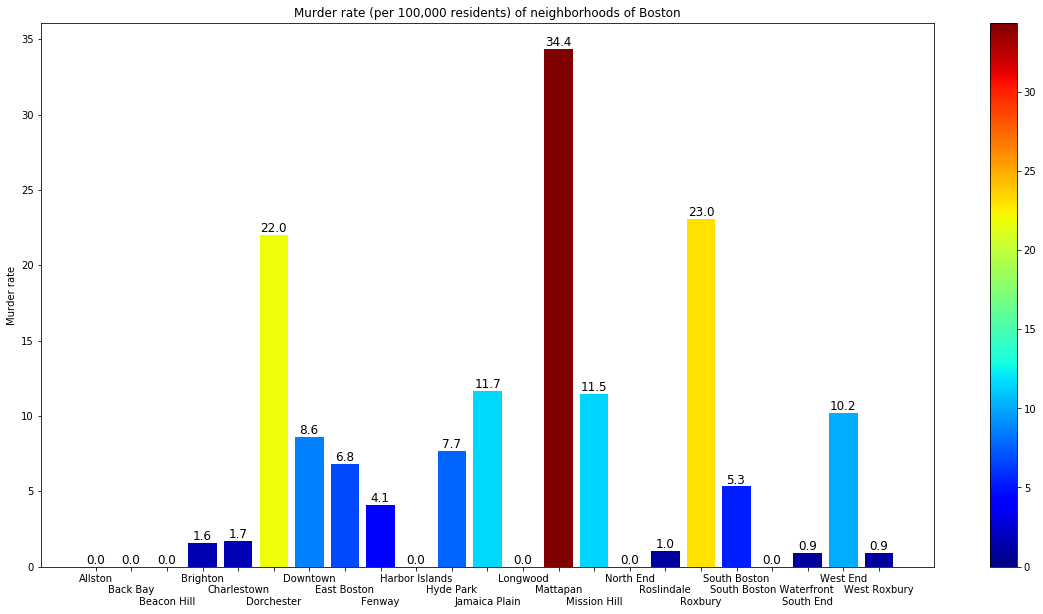

In [809]:
fig01 = plt.figure(figsize = (20,10))
ax01 = plt.subplot(111)
ind01 = np.arange(23)
murder_rate_by_neighborhood = df_nbh_crimes['murder_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = murder_rate_by_neighborhood.min(), vmax = murder_rate_by_neighborhood.max())
rects = ax01.bar(ind01, murder_rate_by_neighborhood, width = 0.8, color = cmap(norm(murder_rate_by_neighborhood.values)))
ax01.set_xticks(ind01)
ax01.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),3))
ax01.set_title('Murder rate (per 100,000 residents) of neighborhoods of Boston')
ax01.set_ylabel('Murder rate')
for rect in rects:
    height = rect.get_height()
    if height >= 9.95:
        hor = rect.get_x() + 0.03
    else:
        hor = rect.get_x() + 0.12
    ax01.text(hor, height + 0.2, "{:.1f}".format(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Allston, Back Bay, Beacon Hill, Harbor Islands, Longwood, North End and South Boston Waterfront are completely murder-free according to our data.

On the other hand Mattapan, Dorchester and Roxbury have high murder rates.

Now let's plot the graph of aggravated assault.

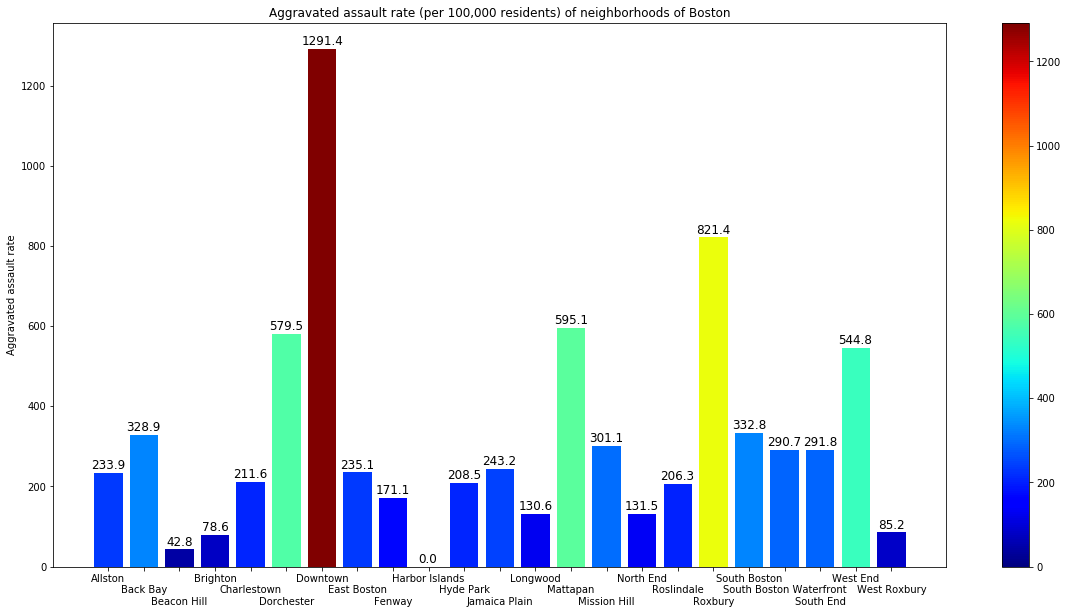

In [825]:
fig02 = plt.figure(figsize = (20,10))
ax02 = plt.subplot(111)
ind02 = np.arange(23)
aa_rate_by_neighborhood = df_nbh_crimes['aggravated_assault_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = aa_rate_by_neighborhood.min(), vmax = aa_rate_by_neighborhood.max())
rects = ax02.bar(ind02, aa_rate_by_neighborhood, width = 0.8, color = cmap(norm(aa_rate_by_neighborhood.values)))
ax02.set_xticks(ind02)
ax02.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),3))
ax02.set_title('Aggravated assault rate (per 100,000 residents) of neighborhoods of Boston')
ax02.set_ylabel('Aggravated assault rate')
for rect in rects:
    height = rect.get_height()
    if height >= 999.95:
        hor = rect.get_x() - 0.16
    elif height >= 99.95:
        hor = rect.get_x() - 0.085
    elif height >= 9.95:
        hor = rect.get_x() + 0.03
    else:
        hor = rect.get_x() + 0.12
    ax02.text(hor, height + 10, "{:.1f}".format(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Harbor Islands, Beacon Hill, Brighton and West Roxbury have low aggravated assault rates. On the other hand Downtown, Roxbury, Mattapan, Dorchester and West End have high aggravated assault rates.

Now let's plot the graph of robbery.

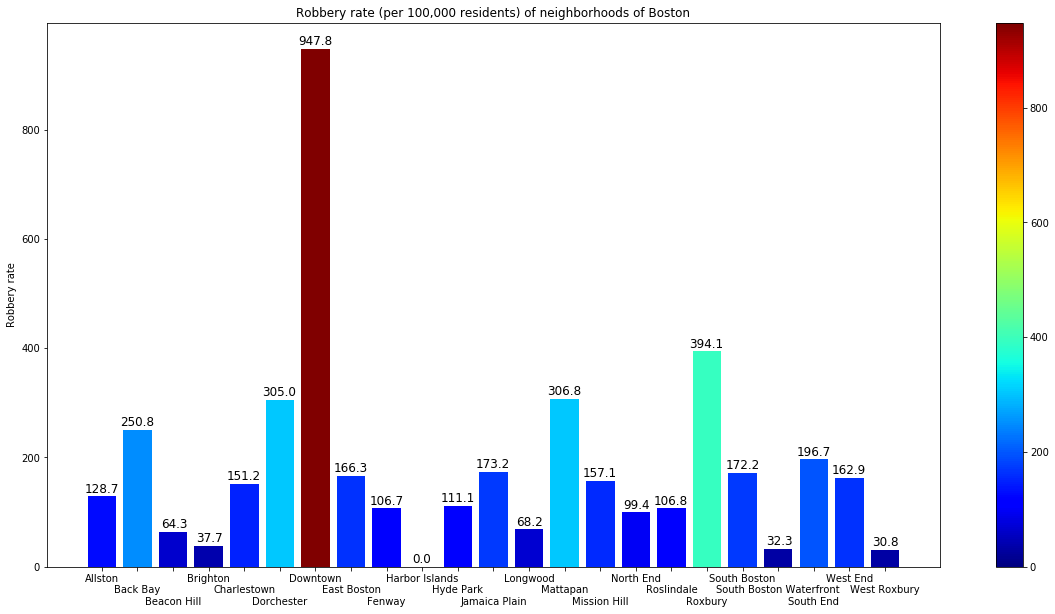

In [815]:
fig03 = plt.figure(figsize = (20,10))
ax03 = plt.subplot(111)
ind03 = np.arange(23)
r_rate_by_neighborhood = df_nbh_crimes['robbery_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = r_rate_by_neighborhood.min(), vmax = r_rate_by_neighborhood.max())
rects = ax03.bar(ind03, r_rate_by_neighborhood, width = 0.8, color = cmap(norm(r_rate_by_neighborhood.values)))
ax03.set_xticks(ind03)
ax03.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),3))
ax03.set_title('Robbery rate (per 100,000 residents) of neighborhoods of Boston')
ax03.set_ylabel('Robbery rate')
for rect in rects:
    height = rect.get_height()
    if height >= 99.95:
        hor = rect.get_x() - 0.09
    elif height >= 9.95:
        hor = rect.get_x() + 0.05
    else:
        hor = rect.get_x() + 0.12
    ax03.text(hor, height + 7, "{:.1f}".format(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Harbor Islands, South Boston Waterfront, Brighton and West Roxbury have low robbery rates. On the other hand Downtown, Roxbury, Mattapan, Dorchester and Back Bay have high robbery rates.

Now let's plot the graph of arson.

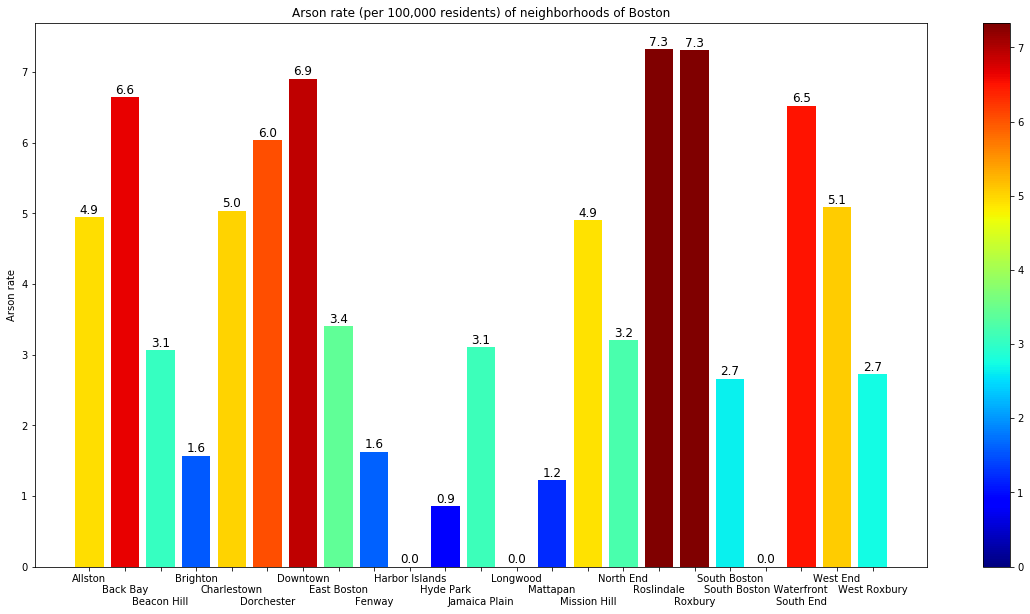

In [830]:
fig04 = plt.figure(figsize = (20,10))
ax04 = plt.subplot(111)
ind04 = np.arange(23)
ar_rate_by_neighborhood = df_nbh_crimes['arson_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = ar_rate_by_neighborhood.min(), vmax = ar_rate_by_neighborhood.max())
rects = ax04.bar(ind04, ar_rate_by_neighborhood, width = 0.8, color = cmap(norm(ar_rate_by_neighborhood.values)))
ax04.set_xticks(ind04)
ax04.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),3))
ax04.set_title('Arson rate (per 100,000 residents) of neighborhoods of Boston')
ax04.set_ylabel('Arson rate')
for rect in rects:
    height = rect.get_height()
    hor = rect.get_x() + 0.13
    ax04.text(hor, height + 0.05, "{:.1f}".format(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Harbor Islands, South Boston Waterfront and Longwood have no arson at all. On the other hand Roslindale, Roxbury, and Downtown have high arson rates.

Now let's plot the graph of auto theft.

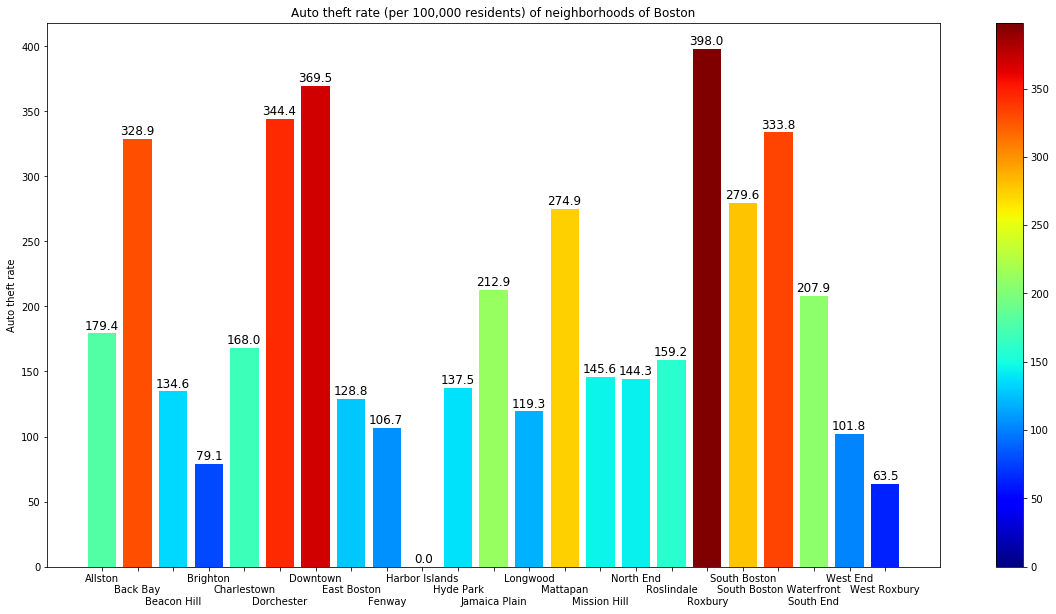

In [847]:
fig05 = plt.figure(figsize = (20,10))
ax05 = plt.subplot(111)
ind05 = np.arange(23)
at_rate_by_neighborhood = df_nbh_crimes['auto_theft_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = at_rate_by_neighborhood.min(), vmax = at_rate_by_neighborhood.max())
rects = ax05.bar(ind05, at_rate_by_neighborhood, width = 0.8, color = cmap(norm(at_rate_by_neighborhood.values)))
ax05.set_xticks(ind05)
ax05.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),3))
ax05.set_title('Auto theft rate (per 100,000 residents) of neighborhoods of Boston')
ax05.set_ylabel('Auto theft rate')
for rect in rects:
    height = rect.get_height()
    if height >= 99.95:
        hor = rect.get_x() - 0.097
    elif height >= 9.95:
        hor = rect.get_x() + 0.04
    else:
        hor = rect.get_x() + 0.16
    ax05.text(hor, height + 3, "{:.1f}".format(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Harbor Islands, West Roxbury and Brighton have low auto theft rates. On the other hand Roslindale, Roxbury, Downtown, Dorchester, South Boston Waterfront and Back Bay have high auto theft rates.

Now let's plot the graph of larceny.

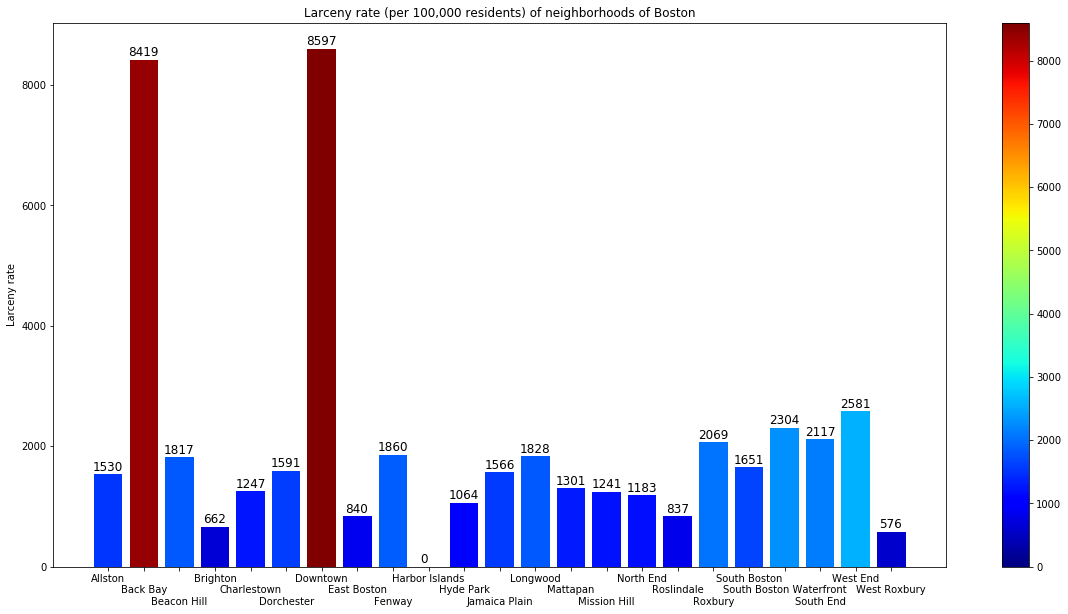

In [860]:
fig06 = plt.figure(figsize = (20,10))
ax06 = plt.subplot(111)
ind06 = np.arange(23)
la_rate_by_neighborhood = df_nbh_crimes['larceny_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = la_rate_by_neighborhood.min(), vmax = la_rate_by_neighborhood.max())
rects = ax06.bar(ind06, la_rate_by_neighborhood, width = 0.8, color = cmap(norm(la_rate_by_neighborhood.values)))
ax06.set_xticks(ind06)
ax06.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),3))
ax06.set_title('Larceny rate (per 100,000 residents) of neighborhoods of Boston')
ax06.set_ylabel('Larceny rate')
for rect in rects:
    height = rect.get_height()
    if height >= 999.95:
        hor = rect.get_x() - 0.03
    elif height >= 99.95:
        hor = rect.get_x() + 0.07
    elif height >= 9.95:
        hor = rect.get_x() + 0.08
    else:
        hor = rect.get_x() + 0.16
    ax06.text(hor, height + 60, int(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Harbor Islands, West Roxbury, Brighton and Roslindale have low larceny rates. On the other hand Downtown and Back Bay have high larceny rates.

Finally let's plot the graph of burglary.

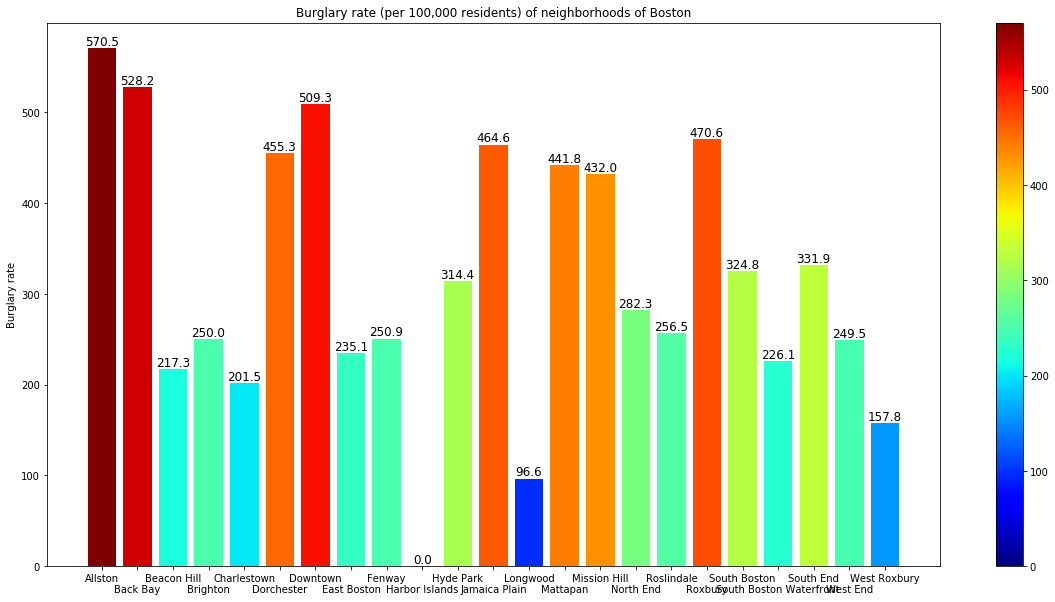

In [865]:
fig07 = plt.figure(figsize = (20,10))
ax07 = plt.subplot(111)
ind07 = np.arange(23)
b_rate_by_neighborhood = df_nbh_crimes['burglary_rate']
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin = b_rate_by_neighborhood.min(), vmax = b_rate_by_neighborhood.max())
rects = ax07.bar(ind07, b_rate_by_neighborhood, width = 0.8, color = cmap(norm(b_rate_by_neighborhood.values)))
ax07.set_xticks(ind07)
ax07.set_xticklabels(multiliner(df_nbh_crimes.index.tolist(),2))
ax07.set_title('Burglary rate (per 100,000 residents) of neighborhoods of Boston')
ax07.set_ylabel('Burglary rate')
for rect in rects:
    height = rect.get_height()
    if height >= 99.95:
        hor = rect.get_x() - 0.082
    elif height >= 9.95:
        hor = rect.get_x() + 0
    else:
        hor = rect.get_x() + 0.16
    ax07.text(hor, height + 3, "{:.1f}".format(height), fontsize = 12)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm)
plt.show()

Harbor Islands, Longwood and West Roxbury have low burglary rates. On the other hand Allston, Back Bay and Downtown have high burglary rates.

<a id = '5'></a>
[Return to top](#top)
# 5. Conclusion

* Fridays in Boston are unusually filled with crimes while the opposite is true for Sundays and to a less extant Saturdays.
* 1sts are unusually full of crimes.
* From 2016 to 2018 crime slightly declined.
* There is more crime during summer months and less crime during winter ones. It's possible that crime is fairly weather-dependent.
* In terms of offense code groups the five most common crimes in Boston are larceny, other, drug violation, simple assault and vandalism.
* In terms of offense descriptions the five most common crimes in Boston are vandalism, assault simple - battery, threats to do bodily harm, larceny theft from building and larceny threat from motor vehicle - non-accessory.
* Police districts B2, D4, C11 and A1 have the most crimes. On the other hand A15, A7, E18 and E13 have the least amount of crimes.
* The most crimes are commited between 4PM and 8PM. Between 1AM and 8AM few crimes are commited. There are two short bumps of crime between 12PM and 1PM and between 12AM and 1AM. On the other hand the period between 1AM and 8AM is fairly crime-free.
* About 0.66% of all crimes involve shooting.
* Allston, Back Bay, Beacon Hill, Harbor Islands, Longwood, North End and South Boston Waterfront are completely murder-free. On the other hand Mattapan, Dorchester and Roxbury have high murder rates.
* Harbor Islands, Beacon Hill, Brighton and West Roxbury have low aggravated assault rates. On the other hand Downtown, Roxbury, Mattapan, Dorchester and West End have high aggravated assault rates.
* Harbor Islands, South Boston Waterfront, Brighton and West Roxbury have low robbery rates. On the other hand Downtown, Roxbury, Mattapan, Dorchester and Back Bay have high robbery rates.
* Harbor Islands, South Boston Waterfront and Longwood have no arson at all. On the other hand Roslindale, Roxbury, and Downtown have high arson rates.
* Harbor Islands, West Roxbury and Brighton have low auto theft rates. On the other hand Roslindale, Roxbury, Downtown, Dorchester, South Boston Waterfront and Back Bay have high auto theft rates.
* Harbor Islands, West Roxbury, Brighton and Roslindale have low larceny rates. On the other hand Downtown and Back Bay have high larceny rates.
* Harbor Islands, Longwood and West Roxbury have low burglary rates. On the other hand Allston, Back Bay and Downtown have high burglary rates.